<a href="https://colab.research.google.com/github/ericr6/platform_analysis/blob/main/deal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task analysis of iExec MArketplace
This notebook create dataframe using the graph,then from the dataframe you can easily create dashboard or explore data.

Section 0 : import and define functions

Section 1 : retrieve latest data, latest N days with parameter N

Section 2 : Monitor hello world

Section 3 : Platform Availability indicator

Section 4 : Visualize recent activity

Section 5 : Save historical data in google drive [DO NOT USE]

Section 6 : Load full historical data from google drive

Section 7 : Visualisation from historical data

## Section 0 : import and define functions


In [1]:
# @title import stuffs
import requests
import json
import csv
from datetime import datetime, timedelta
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# @title Common Functions
# Function to convert Hexa String to Text
def hex_to_string(value):
    if not value:
        return value

    bytes_from_hex = bytes.fromhex(value[2:])
    return bytes_from_hex.decode('utf-8')

def filter_by_time_interval(data_list, date_begin, date_end):
    # Convert date_begin and date_end strings to datetime objects
    #date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S')
    #date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S')

    # Filter data_list based on timestamp falling within the specified time interval
    filtered_data = [row for row in data_list if date_begin <= datetime.utcfromtimestamp(int(row[5])) <= date_end]
    return filtered_data



def get_api_data_iexec_interval(url_query, query, global_skip, date_begin=None, date_end=None):
    total_data = []
    are_data = True
    detected = False
    skip = 0
    while are_data and skip < 200000 or not detected:

        # Construct the query with skip parameter and optional date filters
        query_iter = query.replace("skip_param", str(global_skip + skip))

        options = {
            'headers': {'Content-Type': 'application/json'},
            'data': '{"query": "' + query_iter + '"}',
        }

        response = requests.post(url_query, **options)

        # Check if the response contains valid JSON data
        response.raise_for_status()
        data = response.json()

        array_data = data.get('data', {}).get('taskInitializes', [])

        grouped = [
            [
                e['task']['id'],
                e['task']['deal']['app']['name'],
                hex_to_string(e['task']['deal']['app']['multiaddr']),
                e['task']['deal']['tag'],
                e['task']['status'],
                #pd.to_datetime(int(e['task']['timestamp']) * 1000000).strftime('%Y-%m-%d %H:%M:%S'),
                e['task']['timestamp'],
                e['task']['deal']['workerpool']['id'],
                e['task']['deal']['requester']['id']
            ]
            for e in array_data
        ]

        grouped = filter_by_time_interval(grouped, date_begin, date_end)

        total_data.extend(grouped)
        skip += 500
        _are_data = len(grouped) > 0
        if _are_data > 0 and are_data:
 #           print ("detected is true")
            detected = True
        are_data = len(grouped) > 0
        print("i= " + str(global_skip + skip) + " are_data: " + str(are_data) + "_are_data: " + str(_are_data) + " grouped size " +  str(len(grouped)) + " array_data size: " + str(len(array_data))  )
    return total_data



# Actualize data
url_query_bellecour = 'https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/poco-v5'
query = '{\
                taskInitializes(first:500, skip: skip_param, orderBy: timestamp, orderDirection: desc){\
                  task{\
                    id,\
                    deal{\
                      requester {\
                        id\
                      }\
                      app{\
                        name\
                        multiaddr\
                      }\
                      dataset{\
                        name\
                      }\
                      workerpool{\
                        id\
                         }\
                      tag\
                    }\
                    status,\
                    timestamp\
                  }\
                }\
              }'




In [3]:
# @title Load many Visualization functions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

def taskperday(df,workerpool_id, wpname):

    # Filter the DataFrame further for the specific worker pool
    df_taskday = df[df['WORKERPOOL ID'] == workerpool_id]
    len(df_taskday)

    df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
    # Define the date interval
    start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
    end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

    # Extract month from the DATE column
    df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

    # Group by Month and STATUS, count occurrences
    status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

    plt.title('Tasks per day \n (Workerpool: {}) \n {} Start Date: {} | End Date: {}'.format(workerpool_id, wpname, start_date, end_date))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Status')

    #Upscale resolution
    plt.figure(dpi=300)
    plt.show()


# Assuming df is your DataFrame containing the dApps data
# Filter the DataFrame based on the 'WORKERPOOL ID'
#workerpool_filter = ('0x0e7bc972c99187c191a17f3cae4a2711a4188c3f','0xdb214a4a444d176e22030be1ed89da1b029320f2')
#duration=(1,7,30);


def taskplot(df,workerpool_filter, duration, wp_name):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]

    # Group by app name and date to count the number of uses of each dApp on each date
    app_usage = filtered_df.groupby(['APP NAME', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)

    # Get unique app names for y-axis ticks
    dapp_names = app_usage.index

    # Calculate figsize based on the number of dApps
    fig_height = max(1, len(dapp_names) * 0.5)  # Minimum height of 6 inches
    plt.figure(figsize=(25, fig_height))

    # Plot usage events for each dApp
    for i, app in enumerate(dapp_names):
        usage_dates = filtered_df[filtered_df['APP NAME'] == app]['DATE']
        plt.plot(usage_dates, [i] * len(usage_dates), marker='o', linestyle='', markersize=5, label=app)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Usage of dApps Over Time \n Workerpool: {} \n {} \n Last {} day(s)  [{} -> {}]'.format(wp_name,workerpool_filter, str(duration), start_date_str, end_date_str))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel('dApp')
    plt.yticks(range(len(dapp_names)), dapp_names)  # Set y-axis ticks to be the unique app names
    # Extend y-axis plot
    plt.ylim(-0.5, len(dapp_names) - 0.5)

  #plt.legend()  # Add legend to show dApp names

    plt.grid(axis='y')
    plt.show()


# Success Rate per WorkerPool

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)

def successrate(dftmp, workerpool_filter, duration, wp_name ):
  # Calculate the date range for each time interval
  # Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

  end_date = datetime.now()
  start_date = end_date - timedelta(days=duration)

  # Filter the DataFrame for each time interval
  df_datefiltered = dftmp[(dftmp['DATE'] >= start_date) & (dftmp['DATE'] <= end_date)]

  # Filter the DataFrame further for the specific worker pool
  df_tmp = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_filter]

  # Calculate the total number of tasks and successful tasks for each time interval
  total_tasks = len(df_tmp)
  successful_tasks = len(df_tmp[df_tmp['STATUS'] == 'COMPLETED'])

  # Create a figure with subplots
#  fig, axs = plt.subplots(1, 4, figsize=(20, 8))
  # Plot pie charts for each time interval

  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")
  title=('Success Rate on {} \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name,workerpool_prod, str(duration), start_date_str, end_date_str))

  plot_pie_chart( plt, successful_tasks, total_tasks, title)

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()

def success_repartition(df_tmp, workerpool, duration, wp_name):

    # Filter the DataFrame for the last day
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    df_datefiltered = df_tmp[(df_tmp['DATE'] >= start_date) & (df_tmp['DATE'] <= end_date)]
    # Filter the DataFrame further for the specific worker pool
    df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool]

    # Create a dictionary to map DApp names to colors and marker types
    dapp_info = {}
    for i, dapp in enumerate(df_wpfiltered['APP NAME'].unique()):
        dapp_info[dapp] = {
            'color': plt.cm.tab20(i/len(df_wpfiltered['APP NAME'].unique())),
            'marker': 'o'  # Use the same marker type for each DApp
        }

    # Plot successful and unsuccessful points using the same marker type per DApp
    plt.figure(figsize=(20, 6))
    for dapp, info in dapp_info.items():
        dapp_df = df_wpfiltered[df_wpfiltered['APP NAME'] == dapp]
        success_mask = dapp_df['STATUS'] == 'COMPLETED'

        # Generate random y-coordinates for successful points in the range [0.1, 1]
        random_success_y = np.random.uniform(low=0.1, high=1, size=np.sum(success_mask))
        # Generate random y-coordinates for unsuccessful points in the range [-1, -0.1]
        random_failure_y = np.random.uniform(low=-1, high=-0.1, size=np.sum(~success_mask))

        # Plot successful points
        plt.scatter(dapp_df['DATE'][success_mask], random_success_y, color=info['color'], label=f'{dapp}', marker=info['marker'])
        # Plot unsuccessful points
        plt.scatter(dapp_df['DATE'][~success_mask], random_failure_y, color=info['color'], marker=info['marker'])

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    title=('Tasks Success/fail distribution on \n {}  \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name, workerpool, str(duration), start_date_str, end_date_str))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Task Status')
    plt.yticks([-1, 0, 1], ['Failed', '', 'Success'])

    # Create a single legend for both success and failure
    plt.legend(title='DApp', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()

    plt.show()

def successrate_app(df_tmp, workerpool, wp_name):
    # Filter the DataFrame to include only tasks associated with the specified workerpool
    workerpool_df = df_tmp[df_tmp['WORKERPOOL ID'] == workerpool]

    # Define the date interval
    date_begin = df_tmp['DATE'].min().strftime("%Y-%m-%d")
    date_end = df_tmp['DATE'].max().strftime("%Y-%m-%d")

    # Calculate the success ratio for each DApp within the specified workerpool
    dapp_data = {}
    for dapp, group in workerpool_df.groupby('APP NAME'):
        total_count = group.shape[0]
        success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
        ratio = success_count / total_count if total_count != 0 else 0
        dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

    # Sort the dapp_data dictionary by the total_count of tasks
    sorted_dapp_data = dict(sorted(dapp_data.items(), key=lambda item: item[1]['total_count'], reverse=False))

    # Create a bar plot
    fig_height = max(1, len(sorted_dapp_data) * 0.3)  # Calculate figsize based on the number of dApps
    plt.figure(figsize=(25, fig_height))

    plt.barh(list(sorted_dapp_data.keys()), [d['ratio'] for d in sorted_dapp_data.values()], color='lightgreen', label='Success Ratio')
    plt.xlabel('Success Ratio')
    plt.ylabel('DApp')
    plt.title(f'Success Ratio of Tasks for Each DApp \n ({date_begin} to {date_end}) \n Workerpool {wp_name} : {workerpool}')
    plt.legend()

    # Add annotations for success ratio and total task count
    for i, (dapp, data) in enumerate(sorted_dapp_data.items()):
        plt.text(data['ratio'], i, f'{data["ratio"]:.2f} {data["success_count"]} out of {data["total_count"]} tasks', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Requester Activity Analysis for a defined app in last days

def req_plot(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by app name and date to count the number of uses of each dApp on each date
    # req_usage = filteredapp_df.groupby(['REQUESTER ID', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)
    # Define colors for different statuses
    status_colors = {'COMPLETED': 'green', 'ACTIVE': 'red'}
    address_counts = filteredapp_df['REQUESTER ID'].value_counts()


    # Create a scatter plot with conditional coloring based on the status
    plt.figure(figsize=(20, 14))
    annotated_ids = set()  # Initialize a set to keep track of annotated IDs
    for status, color in status_colors.items():
        status_df = filteredapp_df[filteredapp_df['STATUS'] == status]
        plt.scatter(status_df['DATE'], status_df['REQUESTER ID'], marker='o', color=color, label=status)

        # Annotate points with the number of points for each address
        for idx, row in status_df.iterrows():
            if row['REQUESTER ID'] not in annotated_ids:  # Check if ID has not been annotated yet
                plt.annotate(str(address_counts[row['REQUESTER ID']]), (row['DATE'], row['REQUESTER ID']), textcoords="offset points", xytext=(-10,0), ha='right')
                annotated_ids.add(row['REQUESTER ID'])  # Add ID to annotated set

    # Set plot title and labels
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Scatter Plot of Requesters for \n DApp {} \n Workerpool: {} ; {}\n Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    plt.xlabel('Date')
    plt.ylabel('Requester')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Requester usage of specific app and workerpool in last days

def req_count(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Print the DataFrame completely
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
        print(app_counts_pivot_sorted)

def req_count_with_detail(df, workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)

    # Filter data by date and workerpool
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]

    # First, get APP MULTIADDR analysis
    app_multiaddr_analysis = filteredapp_df.groupby('APP MULTIADDR')['REQUESTER ID'].unique()

    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Add APP MULTIADDR column
    requester_app_multiaddr = filteredapp_df.groupby('REQUESTER ID')['APP MULTIADDR'].first()
    app_counts_pivot['APP MULTIADDR'] = app_counts_pivot.index.map(requester_app_multiaddr)

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Reorder columns to put APP MULTIADDR first
    cols = app_counts_pivot_sorted.columns.tolist()
    final_cols = ['APP MULTIADDR'] + [col for col in cols if col != 'APP MULTIADDR']
    app_counts_pivot_sorted = app_counts_pivot_sorted[final_cols]

    # Print the results
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(
        app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    # Print APP MULTIADDR analysis
    print("\nAPP MULTIADDR Analysis:")
    print("-" * 50)
    for multiaddr, requesters in app_multiaddr_analysis.items():
        print(f"\nAPP MULTIADDR: {multiaddr}")
        print("Associated Requesters:")
        for requester in requesters:
            print(f"  - {requester}")
    print("\n" + "-" * 50 + "\n")

    # Print the main activity table
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print("Detailed Activity by Requester:")
        print(app_counts_pivot_sorted)

    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))



## Section 1 : retrieve latest data


In [ ]:
# @title Get latest data ; Select N Days

#Method 2: with Date
date_end = datetime.now()
date_begin = date_end - timedelta(days=30)

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df_tasks_30d = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID"])
df_tasks_30d["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_tasks_30d["DATE"]]

print("Period observed", df_tasks_30d["DATE"].min(), df_tasks_30d["DATE"].max())
print("dataset length: " + str(df_tasks_30d.shape[0]))

#print(filename)


Period to retrieve: 2025-03-01 09:59:29.580075 2025-03-31 09:59:29.580075
i= 500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 1000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 1500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 2000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 2500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 3000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 3500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 4000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 4500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 5000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 5500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 6000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 6500 are_dat

Check dataset structure and data header, you can share to chatgpt this data structure, and ask him to plot anything you want, he will propose the code, then create a computing box and insert the code directly here to obtain what you ask

In [ ]:
# @title check data set structure

df_tasks_30d.dtypes


,0
TASK_ID,object
APP NAME,object
APP MULTIADDR,object
TAG,object
STATUS,object
DATE,datetime64[ns]
WORKERPOOL ID,object
REQUESTER ID,object


In [ ]:
# @title check dataset header

df_tasks_30d

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID
0,0x9f112a653eaa2c01eb08efb0169af1a75ac258486ea0...,scikit-learn-classification:1.0.0,ericro/scikit-learn-classification:1.0.0,0x00000000000000000000000000000000000000000000...,ACTIVE,2025-03-31 09:58:30,0x4568effcec8ba0787e52deef10ed03267e7c95b1,0x7d7428ffc98cc36dfe2e60c10d0e618454cb8a4b
1,0x7f77eca67be93a66dfeca4d03b79342be835f121d547...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-31 09:57:35,0x0975bfce90f4748dab6d6729c96b33a2cd5491f5,0x7d695b9a362e15090ce26711808bc89c18efa70f
2,0x5a6da86cff42126073df39f780c6e4036c0dbb01e549...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-31 09:57:05,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
3,0x2425170873580bf78437c25c2853a18868a02810ba00...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-31 09:55:20,0xf900995aa41ab29bc16ba0785d7c67ad9d301296,0x7d695b9a362e15090ce26711808bc89c18efa70f
4,0xc3848d2d0db4eebc41a367f510aeb7518b6222ae418f...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-31 09:55:00,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
...,...,...,...,...,...,...,...,...
35694,0x5ee4a542bf2719a569bd0c4bb9ba59795ceea32f3509...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-01 10:03:50,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x3d60589cb7a862e3001b8e7eff1ec248d1f16a18
35695,0x691adf139fcab633137af18a1c60e650c88eb08eaa99...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-01 10:03:50,0xf900995aa41ab29bc16ba0785d7c67ad9d301296,0x7d695b9a362e15090ce26711808bc89c18efa70f
35696,0xc15bf600a8439eb4028e28ba80b4b9db4963fcc39cbc...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-01 10:03:40,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255
35697,0xff67ea3a5107d324c7de0ccb395b0955e1a1a8e7de25...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-03-01 10:02:35,0x0975bfce90f4748dab6d6729c96b33a2cd5491f5,0x7d695b9a362e15090ce26711808bc89c18efa70f


## Section 2 Monitor hello world

In [ ]:
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'

req_plot(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "iexec-hello-world-iapp-0.0.1")

req_count_with_detail(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "iexec-hello-world-iapp-0.0.1")



## Section 3 Platform Availibility


In [ ]:
# @title availibility plot

import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

plt.figure(figsize=(20, 8))

# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
specific_app1 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.5-v14-production'
specific_app2 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.6-v15-production'
# Filter the DataFrame further for the specific worker pool
df_alltime_specific1 = df_tasks_30d[df_tasks_30d['WORKERPOOL ID'] == specific_workerpool_id].copy()

# Filter for specific applications
df_alltime_app1 = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app1].copy()
df_alltime_app2 = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app2].copy()

# Combine the data for both applications
df_alltime_specific = pd.concat([df_alltime_app1, df_alltime_app2])

# Calculate the total minutes since midnight
df_alltime_specific['Minutes'] = df_alltime_specific['DATE'].dt.hour * 60 + df_alltime_specific['DATE'].dt.minute

# Apply modulo operation to get only hour and minutes
df_alltime_specific['Hour_Minutes'] = df_alltime_specific['Minutes'] % (24 * 60)

# Plot successful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['DATE'],
            color='green', label='Completed')

# Plot unsuccessful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['DATE'],
            color='red', label='Other Statuses')

plt.title('Black Box Test')
plt.xlabel('Hours of the Day')
plt.ylabel('Day')

# Create a single legend for both success and failure
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.show()


NameError: name 'df_tasks_30d' is not defined

<Figure size 2000x800 with 0 Axes>

In [ ]:
# @title availibility calculation

import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

# Sort the DataFrame by DATE to ensure sequential observations
df_alltime_specific_sorted = df_alltime_specific.sort_values(by='DATE')
test=df_alltime_specific_sorted
# Initialize variables to track "up" time intervals and downtime intervals
up_intervals = []
down_intervals = []

# Initialize variables to track the start time and count of successful tasks within the interval
start_time = None
success_count = 0
test.index = pd.RangeIndex(1, len(test.index) + 1)
up=pd.Timedelta(0)
down=pd.Timedelta(0)
down_intervals = []

# Iterate over the sorted DataFrame
for index, row in test.iterrows():
    if index < len(test) - 1:
        next_row = test.loc[index + 1]

        # Check if both the current and next observations are COMPLETED
        if (row["STATUS"] == "COMPLETED") and (next_row["STATUS"] == "COMPLETED"):
            # Check if the time between the current and next observations is less than or equal to 22 minutes
            if (next_row['DATE'] - row["DATE"]) <= pd.Timedelta(minutes=22):
                up += next_row['DATE'] - row["DATE"]
            else:
                # If the time between observations is more than 22 minutes, it's considered as down
                down += next_row['DATE'] - row["DATE"]
                down_intervals.append((row['DATE'], next_row["DATE"]))
        else:
            # If either the current or next observation is not COMPLETED, it's considered as down
            down += next_row['DATE'] - row["DATE"]
            down_intervals.append((row['DATE'], next_row["DATE"]))

# Print down intervals
print("Down Intervals:")
for start, end in down_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Merge consecutive intervals
if len(down_intervals) > 0:
    compressed_intervals = []
    start, end = down_intervals[0]
    for interval in down_intervals[1:]:
        if interval[0] - end <= pd.Timedelta(minutes=1):
            end = interval[1]
        else:
            compressed_intervals.append((start, end))
            start, end = interval
    compressed_intervals.append((start, end))

    print("Down compressed:")

# Print compressed intervals
print("\nDown compressed Intervals:")
for start, end in compressed_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Calculate total time, availability percentage
total_time = df_alltime_specific_sorted["DATE"].max() - df_alltime_specific_sorted["DATE"].min()
up_percentage = (up / (up + down)) * 100

# Print summary
print("\nSummary:")
print(f"Total Time: {total_time}")
print(f"Up period: {up}")
print(f"Down period: {down}")
print(f"Availability Percentage: {up_percentage}%")


Downtime Intervals:
 [ 2024-02-17 19:57:25  -> 2024-02-17 20:37:40 ] Duration: 0 days 00:40:15 
 [ 2024-02-20 13:57:50  -> 2024-02-20 14:57:25 ] Duration: 0 days 00:59:35 
 [ 2024-02-21 14:17:20  -> 2024-02-21 14:57:45 ] Duration: 0 days 00:40:25 
 [ 2024-02-23 10:37:50  -> 2024-02-23 12:56:20 ] Duration: 0 days 02:18:30 
 [ 2024-02-27 16:16:40  -> 2024-02-27 16:49:45 ] Duration: 0 days 00:33:05 
 [ 2024-02-27 16:49:45  -> 2024-02-27 17:16:10 ] Duration: 0 days 00:26:25 
 [ 2024-02-29 16:36:30  -> 2024-02-29 16:58:50 ] Duration: 0 days 00:22:20 
 [ 2024-03-01 14:36:30  -> 2024-03-01 15:17:30 ] Duration: 0 days 00:41:00 
 [ 2024-03-01 23:56:35  -> 2024-03-02 00:37:05 ] Duration: 0 days 00:40:30 
 [ 2024-03-02 04:16:20  -> 2024-03-02 04:47:30 ] Duration: 0 days 00:31:10 
 [ 2024-03-02 16:56:30  -> 2024-03-02 17:19:00 ] Duration: 0 days 00:22:30 
 [ 2024-03-03 20:36:45  -> 2024-03-03 20:59:10 ] Duration: 0 days 00:22:25 
 [ 2024-03-05 00:36:20  -> 2024-03-05 01:01:25 ] Duration: 0 days 00

## Section 4 : Visualize recent activity

In [4]:
# @title Load many Visualization functions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

def taskperday(df,workerpool_id, wpname):

    # Filter the DataFrame further for the specific worker pool
    df_taskday = df[df['WORKERPOOL ID'] == workerpool_id]
    len(df_taskday)

    df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
    # Define the date interval
    start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
    end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

    # Extract month from the DATE column
    df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

    # Group by Month and STATUS, count occurrences
    status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

    plt.title('Tasks per day \n (Workerpool: {}) \n {} Start Date: {} | End Date: {}'.format(workerpool_id, wpname, start_date, end_date))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Status')

    #Upscale resolution
    plt.figure(dpi=300)
    plt.show()


# Assuming df is your DataFrame containing the dApps data
# Filter the DataFrame based on the 'WORKERPOOL ID'
#workerpool_filter = ('0x0e7bc972c99187c191a17f3cae4a2711a4188c3f','0xdb214a4a444d176e22030be1ed89da1b029320f2')
#duration=(1,7,30);


def taskplot(df,workerpool_filter, duration, wp_name):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]

    # Group by app name and date to count the number of uses of each dApp on each date
    app_usage = filtered_df.groupby(['APP NAME', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)

    # Get unique app names for y-axis ticks
    dapp_names = app_usage.index

    # Calculate figsize based on the number of dApps
    fig_height = max(1, len(dapp_names) * 0.5)  # Minimum height of 6 inches
    plt.figure(figsize=(25, fig_height))

    # Plot usage events for each dApp
    for i, app in enumerate(dapp_names):
        usage_dates = filtered_df[filtered_df['APP NAME'] == app]['DATE']
        plt.plot(usage_dates, [i] * len(usage_dates), marker='o', linestyle='', markersize=5, label=app)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Usage of dApps Over Time \n Workerpool: {} \n {} \n Last {} day(s)  [{} -> {}]'.format(wp_name,workerpool_filter, str(duration), start_date_str, end_date_str))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel('dApp')
    plt.yticks(range(len(dapp_names)), dapp_names)  # Set y-axis ticks to be the unique app names
    # Extend y-axis plot
    plt.ylim(-0.5, len(dapp_names) - 0.5)

  #plt.legend()  # Add legend to show dApp names

    plt.grid(axis='y')
    plt.show()


# Success Rate per WorkerPool

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)

# Define the date interval
date_begin = df_tasks_30d['DATE'].min().strftime("%Y-%m-%d")
date_end = df_tasks_30d['DATE'].max().strftime("%Y-%m-%d")

# Assuming 'df_tasks_30d' is your DataFrame with task data



def successrate(dftmp, workerpool_filter, duration, wp_name ):
  # Calculate the date range for each time interval
  # Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

  end_date = datetime.now()
  start_date = end_date - timedelta(days=duration)

  # Filter the DataFrame for each time interval
  df_datefiltered = dftmp[(dftmp['DATE'] >= start_date) & (dftmp['DATE'] <= end_date)]

  # Filter the DataFrame further for the specific worker pool
  df_tmp = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_filter]


  # Calculate the total number of tasks and successful tasks for each time interval
  total_tasks = len(df_tmp)
  successful_tasks = len(df_tmp[df_tmp['STATUS'] == 'COMPLETED'])

  # Create a figure with subplots
#  fig, axs = plt.subplots(1, 4, figsize=(20, 8))
  # Plot pie charts for each time interval

  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")
  title=('Success Rate on {} \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name,workerpool_prod, str(duration), start_date_str, end_date_str))

  plot_pie_chart( plt, successful_tasks, total_tasks, title)

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()

def success_repartition(df_tmp, workerpool, duration, wp_name):

    # Filter the DataFrame for the last day
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    df_datefiltered = df_tmp[(df_tmp['DATE'] >= start_date) & (df_tmp['DATE'] <= end_date)]
    # Filter the DataFrame further for the specific worker pool
    df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool]

    # Create a dictionary to map DApp names to colors and marker types
    dapp_info = {}
    for i, dapp in enumerate(df_wpfiltered['APP NAME'].unique()):
        dapp_info[dapp] = {
            'color': plt.cm.tab20(i/len(df_wpfiltered['APP NAME'].unique())),
            'marker': 'o'  # Use the same marker type for each DApp
        }

    # Plot successful and unsuccessful points using the same marker type per DApp
    plt.figure(figsize=(20, 6))
    for dapp, info in dapp_info.items():
        dapp_df = df_wpfiltered[df_wpfiltered['APP NAME'] == dapp]
        success_mask = dapp_df['STATUS'] == 'COMPLETED'

        # Generate random y-coordinates for successful points in the range [0.1, 1]
        random_success_y = np.random.uniform(low=0.1, high=1, size=np.sum(success_mask))
        # Generate random y-coordinates for unsuccessful points in the range [-1, -0.1]
        random_failure_y = np.random.uniform(low=-1, high=-0.1, size=np.sum(~success_mask))

        # Plot successful points
        plt.scatter(dapp_df['DATE'][success_mask], random_success_y, color=info['color'], label=f'{dapp}', marker=info['marker'])
        # Plot unsuccessful points
        plt.scatter(dapp_df['DATE'][~success_mask], random_failure_y, color=info['color'], marker=info['marker'])

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    title=('Tasks Success/fail distribution on \n {}  \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name, workerpool, str(duration), start_date_str, end_date_str))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Task Status')
    plt.yticks([-1, 0, 1], ['Failed', '', 'Success'])

    # Create a single legend for both success and failure
    plt.legend(title='DApp', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()

    plt.show()

def successrate_app(df_tmp, workerpool, wp_name):
    # Filter the DataFrame to include only tasks associated with the specified workerpool
    workerpool_df = df_tmp[df_tmp['WORKERPOOL ID'] == workerpool]

    # Define the date interval
    date_begin = df_tmp['DATE'].min().strftime("%Y-%m-%d")
    date_end = df_tmp['DATE'].max().strftime("%Y-%m-%d")

    # Calculate the success ratio for each DApp within the specified workerpool
    dapp_data = {}
    for dapp, group in workerpool_df.groupby('APP NAME'):
        total_count = group.shape[0]
        success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
        ratio = success_count / total_count if total_count != 0 else 0
        dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

    # Sort the dapp_data dictionary by the total_count of tasks
    sorted_dapp_data = dict(sorted(dapp_data.items(), key=lambda item: item[1]['total_count'], reverse=False))

    # Create a bar plot
    fig_height = max(1, len(sorted_dapp_data) * 0.3)  # Calculate figsize based on the number of dApps
    plt.figure(figsize=(25, fig_height))

    plt.barh(list(sorted_dapp_data.keys()), [d['ratio'] for d in sorted_dapp_data.values()], color='lightgreen', label='Success Ratio')
    plt.xlabel('Success Ratio')
    plt.ylabel('DApp')
    plt.title(f'Success Ratio of Tasks for Each DApp \n ({date_begin} to {date_end}) \n Workerpool {wp_name} : {workerpool}')
    plt.legend()

    # Add annotations for success ratio and total task count
    for i, (dapp, data) in enumerate(sorted_dapp_data.items()):
        plt.text(data['ratio'], i, f'{data["ratio"]:.2f} {data["success_count"]} out of {data["total_count"]} tasks', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Requester Activity Analysis for a defined app in last days

def req_plot(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by app name and date to count the number of uses of each dApp on each date
    # req_usage = filteredapp_df.groupby(['REQUESTER ID', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)
    # Define colors for different statuses
    status_colors = {'COMPLETED': 'green', 'ACTIVE': 'red'}
    address_counts = filteredapp_df['REQUESTER ID'].value_counts()


    # Create a scatter plot with conditional coloring based on the status
    plt.figure(figsize=(20, 14))
    annotated_ids = set()  # Initialize a set to keep track of annotated IDs
    for status, color in status_colors.items():
        status_df = filteredapp_df[filteredapp_df['STATUS'] == status]
        plt.scatter(status_df['DATE'], status_df['REQUESTER ID'], marker='o', color=color, label=status)

        # Annotate points with the number of points for each address
        for idx, row in status_df.iterrows():
            if row['REQUESTER ID'] not in annotated_ids:  # Check if ID has not been annotated yet
                plt.annotate(str(address_counts[row['REQUESTER ID']]), (row['DATE'], row['REQUESTER ID']), textcoords="offset points", xytext=(-10,0), ha='right')
                annotated_ids.add(row['REQUESTER ID'])  # Add ID to annotated set

    # Set plot title and labels
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Scatter Plot of Requesters for \n DApp {} \n Workerpool: {} ; {}\n Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    plt.xlabel('Date')
    plt.ylabel('Requester')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Requester usage of specific app and workerpool in last days

def req_count(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Print the DataFrame completely
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
        print(app_counts_pivot_sorted)



NameError: name 'df_tasks_30d' is not defined

In [ ]:
# @title Visualization per workerpool

# By worlerpool

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
v8_learn_prod = '0x0975bfce90f4748dab6d6729c96b33a2cd5491f5'
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'
wp_tdx = "0x4568effcec8ba0787e52deef10ed03267e7c95b1"


## V8-debug

taskperday(df_tasks_30d, workerpool_debug,"V8-debug")

taskplot(df_tasks_30d, workerpool_debug, 1, "V8_debug")
taskplot(df_tasks_30d, workerpool_debug, 7, "V8_debug")
taskplot(df_tasks_30d, workerpool_debug, 30, "V8_debug")

successrate(df_tasks_30d, workerpool_debug, 1,  "V8-debug")
successrate(df_tasks_30d, workerpool_debug, 7,  "V8-debug")
successrate(df_tasks_30d, workerpool_debug, 30, "V8-debug")

success_repartition(df_tasks_30d,workerpool_debug,1, "V8_debug")
success_repartition(df_tasks_30d,workerpool_debug,7, "V8_debug")
success_repartition(df_tasks_30d,workerpool_debug,30, "V8_debug")

successrate_app(df_tasks_30d, workerpool_debug, "V8-debug")

req_plot(df_tasks_30d, workerpool_debug, 30, "V8_debug", "first-poc")
req_plot(df_tasks_30d, workerpool_debug, 30, "V8_debug", "hello-world-scone")

## V8-prod

taskperday(df_tasks_30d, workerpool_prod,"V8-prod")

taskplot(df_tasks_30d, workerpool_prod, 1, "V8_prod")
taskplot(df_tasks_30d, workerpool_prod, 7, "V8_prod")
taskplot(df_tasks_30d, workerpool_prod, 30, "V8_prod")

successrate(df_tasks_30d, workerpool_prod, 1,  "V8-prod")
successrate(df_tasks_30d, workerpool_prod, 7,  "V8-prod")
successrate(df_tasks_30d, workerpool_prod, 30, "V8-prod")

success_repartition(df_tasks_30d,workerpool_prod,1, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,7, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,30, "V8_prod")

successrate_app(df_tasks_30d, workerpool_prod, "V8_prod")

req_plot(df_tasks_30d, workerpool_prod, 30, "V8_prod", "web3mail")
req_plot(df_tasks_30d, workerpool_prod, 30, "V8_prod", "generic-oracle-dapp")

req_count(df_tasks_30d, workerpool_prod, 30, "V8_prod", "web3mail")
#req_count(df_tasks_30d, workerpool_prod, 30, "V8_prod", "generic-oracle-dapp")

## V8-learn-prod

taskperday(df_tasks_30d,v8_learn_prod, "V8-learn-prod")

taskplot(df_tasks_30d, v8_learn_prod, 1, "V8-learn-prod")
taskplot(df_tasks_30d, v8_learn_prod, 7, "V8-learn-prod")
taskplot(df_tasks_30d, v8_learn_prod, 30, "V8-learn-prod")

successrate(df_tasks_30d, v8_learn_prod, 1,  "v8_learn_prod")
successrate(df_tasks_30d, v8_learn_prod, 7,  "v8_learn_prod")
successrate(df_tasks_30d, v8_learn_prod, 30, "v8_learn_prod")

success_repartition(df_tasks_30d, v8_learn_prod,1, "V8_learn_prod")
success_repartition(df_tasks_30d, v8_learn_prod,7, "V8_learn_prod")
success_repartition(df_tasks_30d, v8_learn_prod,30, "V8_learn_prod")

successrate_app(df_tasks_30d, v8_learn_prod, "V8_learn_prod")

## V8-learn-debug

taskperday(df_tasks_30d, v8_learn_debug, "V8-learn-debug")

taskplot(df_tasks_30d, v8_learn_debug, 1, "V8-learn-debug")
taskplot(df_tasks_30d, v8_learn_debug, 7, "V8-learn-debug")
taskplot(df_tasks_30d, v8_learn_debug, 30, "V8-learn-debug")

successrate(df_tasks_30d, v8_learn_debug, 1,  "v8_learn_debug")
successrate(df_tasks_30d, v8_learn_debug, 7,  "v8_learn_debug")
successrate(df_tasks_30d, v8_learn_debug, 30, "v8_learn_debug")

success_repartition(df_tasks_30d, v8_learn_debug,1, "V8_learn_debug")
success_repartition(df_tasks_30d, v8_learn_debug,7, "V8_learn_debug")
success_repartition(df_tasks_30d, v8_learn_debug,30, "V8_learn_debug")

successrate_app(df_tasks_30d, v8_learn_debug, "V8_learn_debug")

#req_plot(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "lejamon/tee_private_airdrop_claim")
#req_count(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "lejamon/tee_private_airdrop_claim")

## wp_tdx

taskperday(df_tasks_30d, wp_tdx, "wp_tdx")

taskplot(df_tasks_30d, wp_tdx, 1, "wp_tdx")
taskplot(df_tasks_30d, wp_tdx, 7, "wp_tdx")
taskplot(df_tasks_30d, wp_tdx, 30, "wp_tdx")

#successrate(df_tasks_30d, wp_tdx, 1,  "wp_tdx")
#successrate(df_tasks_30d, wp_tdx, 7,  "wp_tdx")
#successrate(df_tasks_30d, wp_tdx, 30, "wp_tdx")

success_repartition(df_tasks_30d, wp_tdx,1, "wp_tdx")
success_repartition(df_tasks_30d, wp_tdx,7, "wp_tdx")
success_repartition(df_tasks_30d, wp_tdx,30, "wp_tdx")

successrate_app(df_tasks_30d, v8_learn_debug, "wp_tdx")

In [ ]:
# @title Crosstab

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming df is your DataFrame containing the data grouped by app name and worker pool ID
crosstab = pd.crosstab(df_tasks_30d['APP NAME'], df_tasks_30d['WORKERPOOL ID'], margins=True, margins_name='Total')

# Remove the 'Total' column and row
crosstab = crosstab.drop('Total', axis=0)
crosstab = crosstab.drop('Total', axis=1)

# Calculate the total usage of each app across all worker pools
app_total_usage = crosstab.sum(axis=1)

# Sort the apps based on total usage
sorted_apps = app_total_usage.sort_values(ascending=False).index

# Reindex the crosstab DataFrame based on the sorted apps
crosstab_sorted = crosstab.reindex(index=sorted_apps)

# Create a heatmap using Seaborn
plt.figure(figsize=(22, 22))
heatmap = sns.heatmap(crosstab_sorted, annot=True, fmt='d', cmap='viridis')

plt.title('APP vs workerpool')

# Set xlabel on top
plt.xlabel('WORKERPOOL ID', fontsize=14, labelpad=20, ha='center')

heatmap.xaxis.tick_top()
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='left')

plt.show()


In [ ]:
# @title Extract tasks in failure on the last 24 hours on V8-prod workerpool

from datetime import datetime, timedelta

# Define the date range for the last days
end_date = datetime.now()
start_date = end_date - timedelta(days=1)  # Adjust the number of days as needed

# Filter the DataFrame for the specified date range and workerpool ID
filtered_df = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date) & (df_tasks_30d['DATE'] <= end_date) & (df_tasks_30d['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f') & (df_tasks_30d['STATUS'] != 'COMPLETED')]

# Exclude successful tasks
filtered_df = filtered_df[filtered_df['STATUS'] != 'success']

# Group by 'APP NAME' and aggregate Task IDs as a list
unsuccessful_dapps_per_name = filtered_df.groupby('APP NAME')['TASK_ID'].agg(list)

# Display the result
for app_name, task_ids in unsuccessful_dapps_per_name.items():
    print(f"Unsuccessful DApp: {app_name}")
    for task_id in task_ids:
        print(f"Task ID: {task_id}")
    print()

In [ ]:
# @title tops apps, wp, requesters

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset is stored in a DataFrame named df

# Top 5 Apps
top_apps = df_tasks_30d['APP NAME'].value_counts().nlargest(100)
plt.figure(figsize=(12, 12))
sns.barplot(y=top_apps.index, x=top_apps.values, palette='viridis')
plt.title('Top 5 Apps')
plt.xlabel('App Name')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()

# Top 5 Worker Pools
top_workerpools = df_tasks_30d['WORKERPOOL ID'].value_counts().nlargest(100)
plt.figure(figsize=(12,12))
sns.barplot(y=top_workerpools.index, x=top_workerpools.values, palette='magma')
plt.title('Top 5 Worker Pools')
plt.xlabel('Worker Pool ID')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()

# Top 5 Requesters
top_requesters = df_tasks_30d['REQUESTER ID'].value_counts().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_requesters.index, x=top_requesters.values, palette='plasma')
plt.title('Top 5 Requesters')
plt.xlabel('Requester ID')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()


In [ ]:
# @title Top apps in last days

import pandas as pd

# Filter the DataFrame for the last day
duration=30
end_date = datetime.now()
start_date = end_date - timedelta(days=duration)
df_datefiltered = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date) & (df_tasks_30d['DATE'] <= end_date)]

# Filter the DataFrame further for the specific worker pool
df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_debug]

# Group by 'APP NAME' and 'STATUS' and count occurrences
app_counts = df_wpfiltered.groupby(['APP NAME', 'STATUS']).size()

# Reset index to make 'APP NAME' and 'STATUS' as columns
app_counts_df = app_counts.reset_index(name='Number of Occurrences')

# Pivot the DataFrame to have 'STATUS' as columns
app_counts_pivot = app_counts_df.pivot(index='APP NAME', columns='STATUS', values='Number of Occurrences')

# Replace NaN values with zero
app_counts_pivot.fillna(0, inplace=True)

# Convert the DataFrame to use integer data type
app_counts_pivot = app_counts_pivot.astype(int)

# Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

# Sort the DataFrame based on 'COMPLETED' column
app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

# Print the DataFrame completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
    print(app_counts_pivot_sorted)


## Section 5 : Save historical data in google drive

Pre requisite : Google Drive connected
Save data in google Drive, Control filename to avoid overwrite existing dataset

In [ ]:
# @title Save data in csv file on google drive [USE CAREFULLY!!!!!!]
from google.colab import drive
drive.mount('/content/drive')

#Define the period

#Method 1 with test
date_begin = '2024-02-01 00:00:00'
date_end = '2024-03-01 00:00:00'

filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/Dataset_2024_02.csv'
date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S')
date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S')

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID"])
df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]

print("Period observed", df["DATE"].min(), df["DATE"].max())
print("dataset length: " + str(df.shape[0]))

#print(filename)
#date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#new_filename = f"{filename}.csv"

# Save the DataFrame to CSV with the new filename
#df.to_csv(filename, index=False)


Period to retrieve: 2024-02-01 00:00:00 2024-03-01 00:00:00
i= 500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 1000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 1500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 2000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 2500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 3000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 3500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 4000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 4500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 5000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 5500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 6000 are_data: True_are_data: True grouped size 426 array_data size: 500
i= 6500 are_data: True_are_da

## Section 6 : Load full historical data from google drive


In [5]:
# @title Load dataset from csv file store on google drive

import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Directory containing CSV files
directory='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/'

# List to store DataFrames from each CSV file
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        dftmp = pd.read_csv(filepath)
        dftmp['DATE'] = pd.to_datetime(dftmp['DATE'])
        _begin = dftmp['DATE'].min().strftime("%Y-%m-%d")
        _end = dftmp['DATE'].max().strftime("%Y-%m-%d")
        print(str(filename) + " " + str(_begin) + " " + str(_end))
        # Append DataFrame to the list
        dfs.append(dftmp)

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)


_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")
print("global dataframe: " + str(concatenated_df.shape) +" " + str(_begin) + " " + str(_end))


Mounted at /content/drive
Dataset_2024_04.csv 2024-04-01 2024-04-30
Dataset_2024_03.csv 2024-03-01 2024-03-31
Dataset_2024_02.csv 2024-02-01 2024-02-29
Dataset_2024_01.csv 2024-01-01 2024-01-31
Dataset_2023_12.csv 2023-12-01 2023-12-31
Dataset_2023_11.csv 2023-11-01 2023-11-30
Dataset_2023_10.csv 2023-10-01 2023-10-31
Dataset_2023_09.csv 2023-09-01 2023-09-30
Dataset_2023_08.csv 2023-08-01 2023-08-31
Dataset_2023_01.csv 2023-01-01 2023-01-31
Dataset_2023_07.csv 2023-07-01 2023-07-31
Dataset_2023_06.csv 2023-06-01 2023-06-30
Dataset_2023_05.csv 2023-05-01 2023-05-31
Dataset_2023_04.csv 2023-04-01 2023-04-30
Dataset_2023_03.csv 2023-03-01 2023-03-31
Dataset_2022_S2.csv 2022-07-01 2022-12-31
Dataset_2023_02.csv 2023-02-01 2023-02-28
Dataset_2022_S1.csv 2022-01-01 2022-06-30
Dataset_2021.csv 2021-01-01 2021-12-31
Dataset_2020.csv 2020-07-15 2020-12-31
Dataset_2024_05.csv 2024-05-01 2024-05-31
Dataset_2024_06.csv 2024-06-01 2024-06-30
Dataset_2024_07.csv 2024-07-01 2024-07-31
Dataset_2024_0

In [6]:
# @title show header

concatenated_df

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID
0,0xdc874cd6dc6c329ec043db4bf6d88e04f2cd8ead4d70...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-04-30 23:59:40,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
1,0xb9bd2e2344fd5d485bd376d3623f197374c9afcc0391...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-04-30 23:58:50,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x3d60589cb7a862e3001b8e7eff1ec248d1f16a18
2,0x77389202d3348b30e74079c7972a73abddae48dc093c...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-04-30 23:59:35,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x5d62abd17f0a7f1004c981d5cff24c5a88d849f5
3,0xbc4d3651db909f32da7eec0ec288954aafcd79136fe2...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-04-30 23:56:45,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
4,0x7d3d7e172761de3b3c29488298750eaa748e7b74001f...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-04-30 23:55:25,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255
...,...,...,...,...,...,...,...,...
1264067,0x5a1ffe00d7e19858c560b50c143ad5ac5b3b50f42d97...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-04-01 00:05:20,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
1264068,0x410827ea3e2cd77a8d3d4055f600c4bb3407a424960f...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-04-01 00:03:05,0x0975bfce90f4748dab6d6729c96b33a2cd5491f5,0x7d695b9a362e15090ce26711808bc89c18efa70f
1264069,0xc4a018fc3ba135decdddbe83037539e24353ca4a0a11...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-04-01 00:02:00,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
1264070,0x52d735d93ce5171a374df05fecbf3738df6473c68766...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-04-01 00:00:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c


In [7]:
# @title Display dataset struture and date info

print("Period observed", concatenated_df["DATE"].min(), concatenated_df["DATE"].max())

print("dataset length: " + str(concatenated_df.shape[0]))

concatenated_df.dtypes


Period observed 2020-07-15 15:00:15 2025-05-01 00:00:00
dataset length: 1264072


,0
TASK_ID,object
APP NAME,object
APP MULTIADDR,object
TAG,object
STATUS,object
DATE,datetime64[ns]
WORKERPOOL ID,object
REQUESTER ID,object


## Section 7 : Visualize full historical data

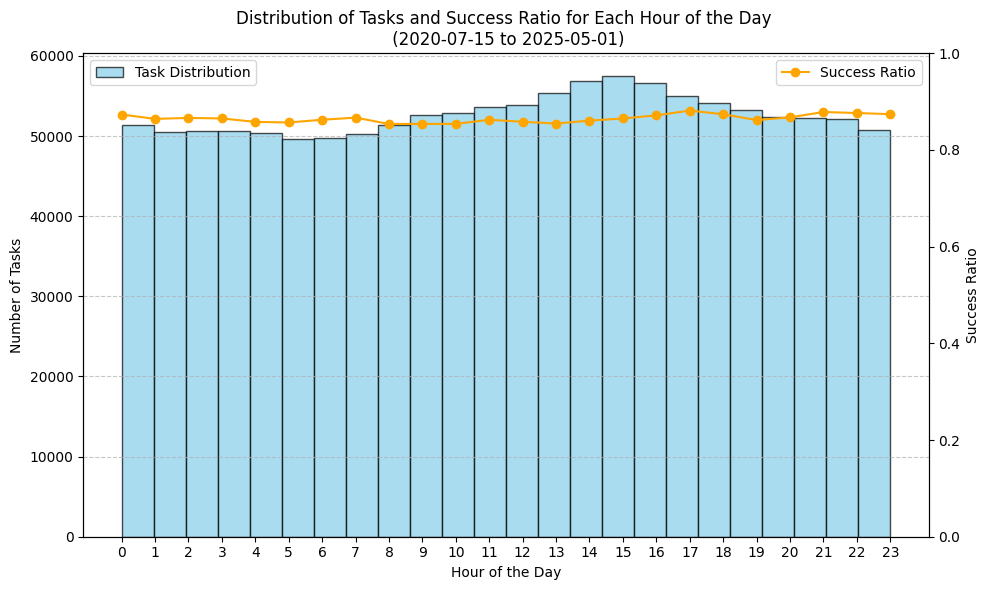

In [8]:
# @title Monthly distribution

import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Extract the hour component from the 'DATE' column
concatenated_df['Hour'] = concatenated_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day
task_counts = concatenated_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day
success_counts = concatenated_df[concatenated_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day
ax1.hist(concatenated_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end})')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-9-6aad8b68829c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workerpool_df['Hour'] = workerpool_df['DATE'].dt.hour


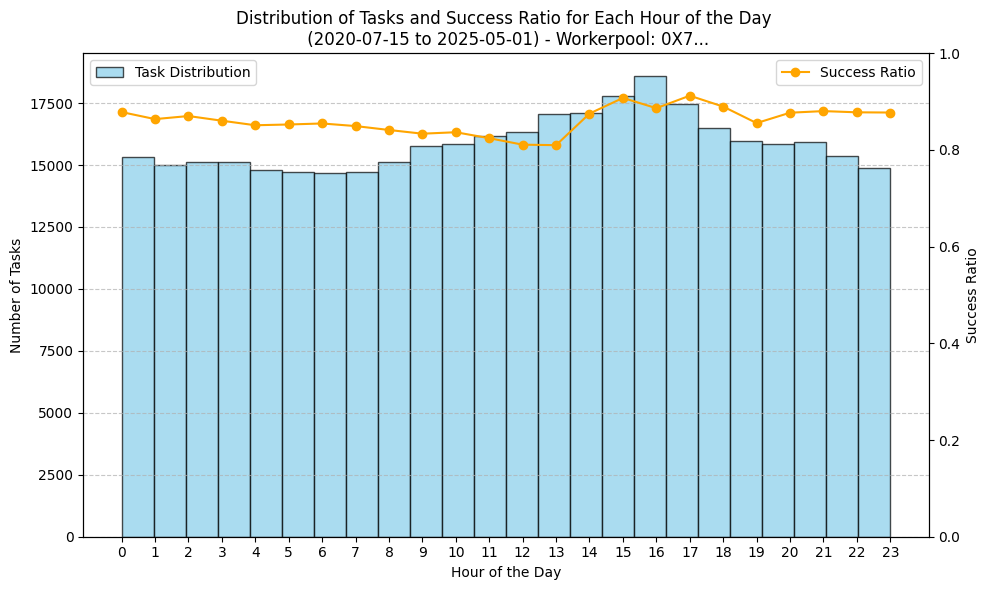

In [9]:
# @title Distribution of Tasks and Success Ratio for Each Hour of the Day


import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f']  # Replace '0X7...' with the actual workerpool ID

# Extract the hour component from the 'DATE' column
workerpool_df['Hour'] = workerpool_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day within the specified workerpool
task_counts = workerpool_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day within the specified workerpool
ax1.hist(workerpool_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end}) - Workerpool: 0X7...')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-10-f665f12ecd34>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workerpool_df['Day of Week'] = workerpool_df['DATE'].dt.dayofweek


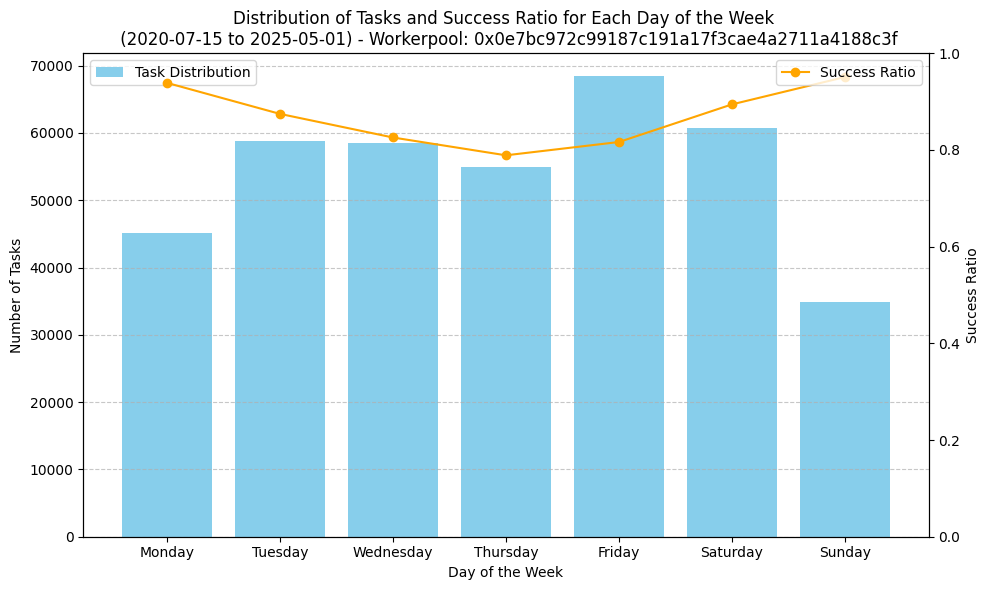

In [10]:
# @title Distribution of Tasks and Success Ratio for Each Day of the Week

import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f']  # Replace '0X7...' with the actual workerpool ID

# Extract the day of the week component from the 'DATE' column
workerpool_df['Day of Week'] = workerpool_df['DATE'].dt.dayofweek

# Calculate the total number of tasks for each day of the week within the specified workerpool
task_counts = workerpool_df.groupby('Day of Week').size()

# Calculate the success ratio for each day of the week within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Day of Week').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each day of the week within the specified workerpool
ax1.bar(range(7), task_counts, color='skyblue', label='Task Distribution')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Day of the Week \n ({date_begin} to {date_end}) - Workerpool: 0x0e7bc972c99187c191a17f3cae4a2711a4188c3f')
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(7), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


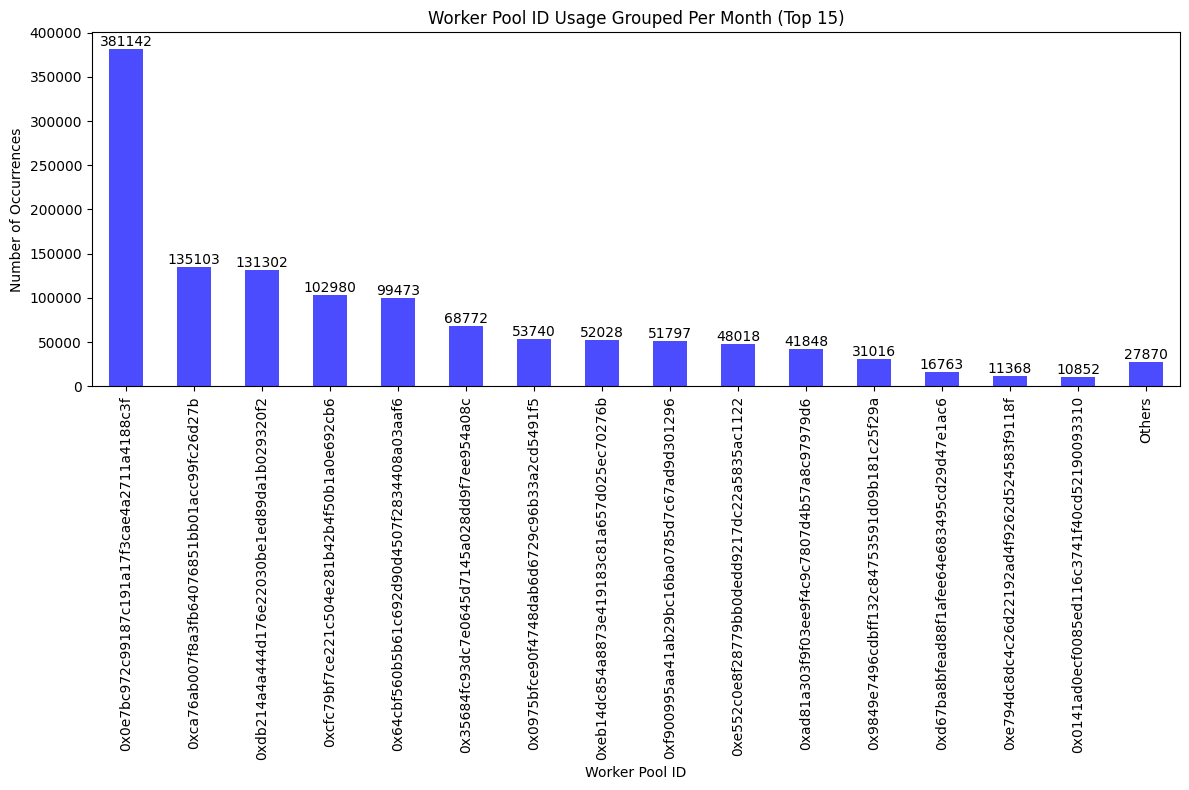

In [11]:
# @title Worker Pool ID Usage

import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'DATE' column is in datetime format
concatenated_df['DATE'] = pd.to_datetime(concatenated_df['DATE'])

# Extract month and year from the 'DATE' column
concatenated_df['MONTH'] = concatenated_df['DATE'].dt.month
concatenated_df['YEAR'] = concatenated_df['DATE'].dt.year

# Group by 'WORKERPOOL ID', 'YEAR', and 'MONTH', and count the occurrences
usage_per_month = concatenated_df.groupby(['WORKERPOOL ID', 'YEAR', 'MONTH']).size().reset_index(name='COUNT')

# Aggregate the counts of all worker pool IDs
total_counts = usage_per_month.groupby('WORKERPOOL ID')['COUNT'].sum()

# Select the top 15 worker pool IDs
top_15_workerpool = total_counts.nlargest(15)

# Group the rest into a new label "Others"
other_count = total_counts.drop(top_15_workerpool.index).sum()

# Combine the counts of the top 15 IDs and the rest
combined_counts = pd.concat([top_15_workerpool, pd.Series({'Others': other_count})])

# Plot the worker pool ID distribution usage grouped per month
plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color='blue', alpha=0.7)

# Add labels outside the plot
for i, (label, count) in enumerate(combined_counts.items()):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

plt.title('Worker Pool ID Usage Grouped Per Month (Top 15)')
plt.xlabel('Worker Pool ID')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()


<ipython-input-12-60d12a63f497>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['Month'] = tmp_df['DATE'].dt.to_period('M')


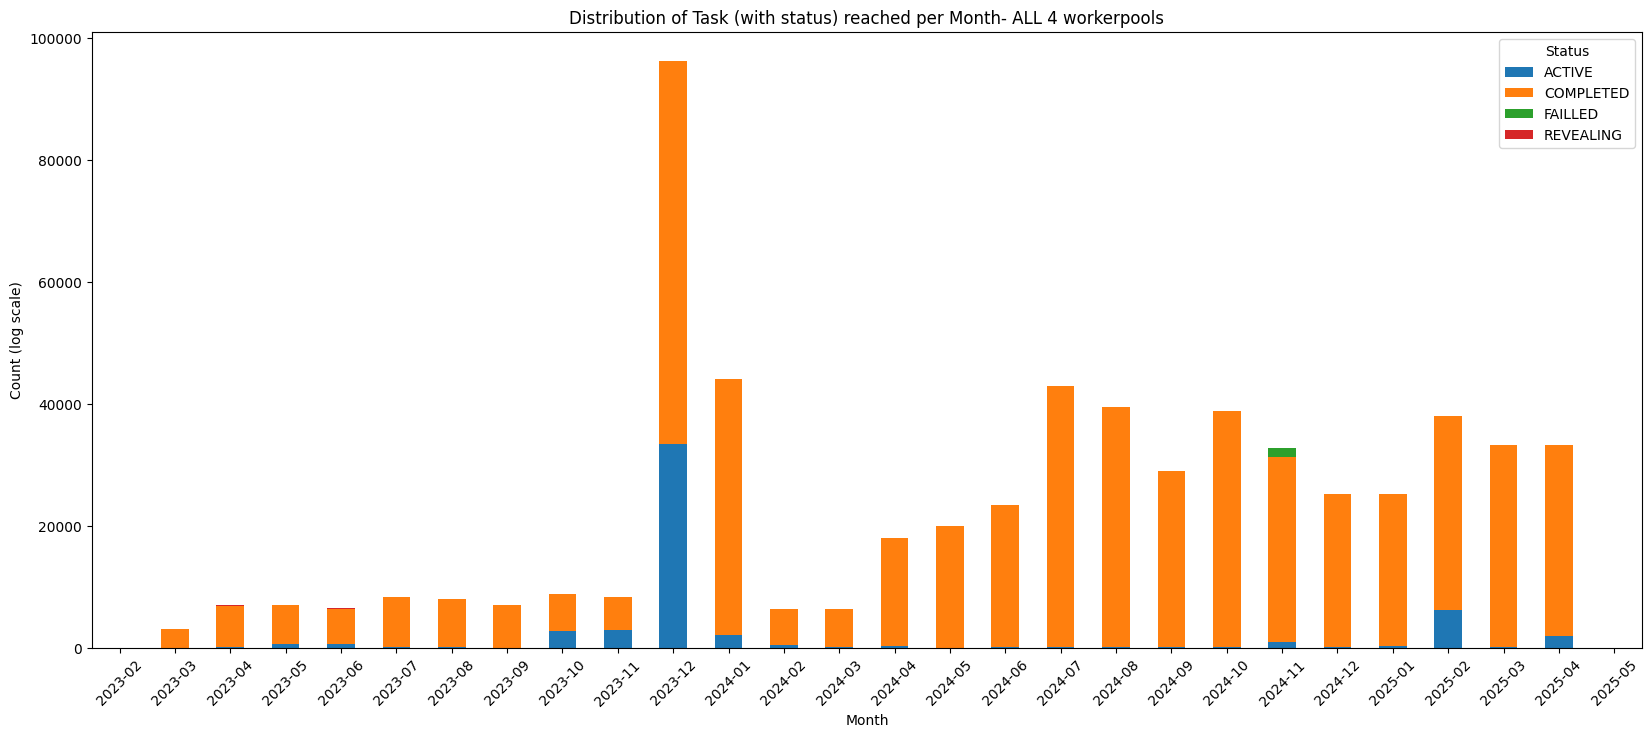

In [12]:
# @title Activity on 4 main workerpools

import pandas as pd
import matplotlib.pyplot as plt

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
v8_learn_prod = '0x0975bfce90f4748dab6d6729c96b33a2cd5491f5'
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
concatenated_df['DATE'] = pd.to_datetime(concatenated_df['DATE'])
tmp_df = concatenated_df[
    (concatenated_df['WORKERPOOL ID'] == workerpool_prod) |
    (concatenated_df['WORKERPOOL ID'] == workerpool_debug) |
    (concatenated_df['WORKERPOOL ID'] == v8_learn_debug) |
    (concatenated_df['WORKERPOOL ID'] == v8_learn_prod)
]
# Extract month from the DATE column
tmp_df['Month'] = tmp_df['DATE'].dt.to_period('M')

# Group by Month and STATUS, count occurrences
status_counts = tmp_df.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Distribution of Task (with status) reached per Month- ALL 4 workerpools')
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

# Change y-axis to log scale
# plt.yscale('log')

plt.show()



<ipython-input-13-cd23dae5b53f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


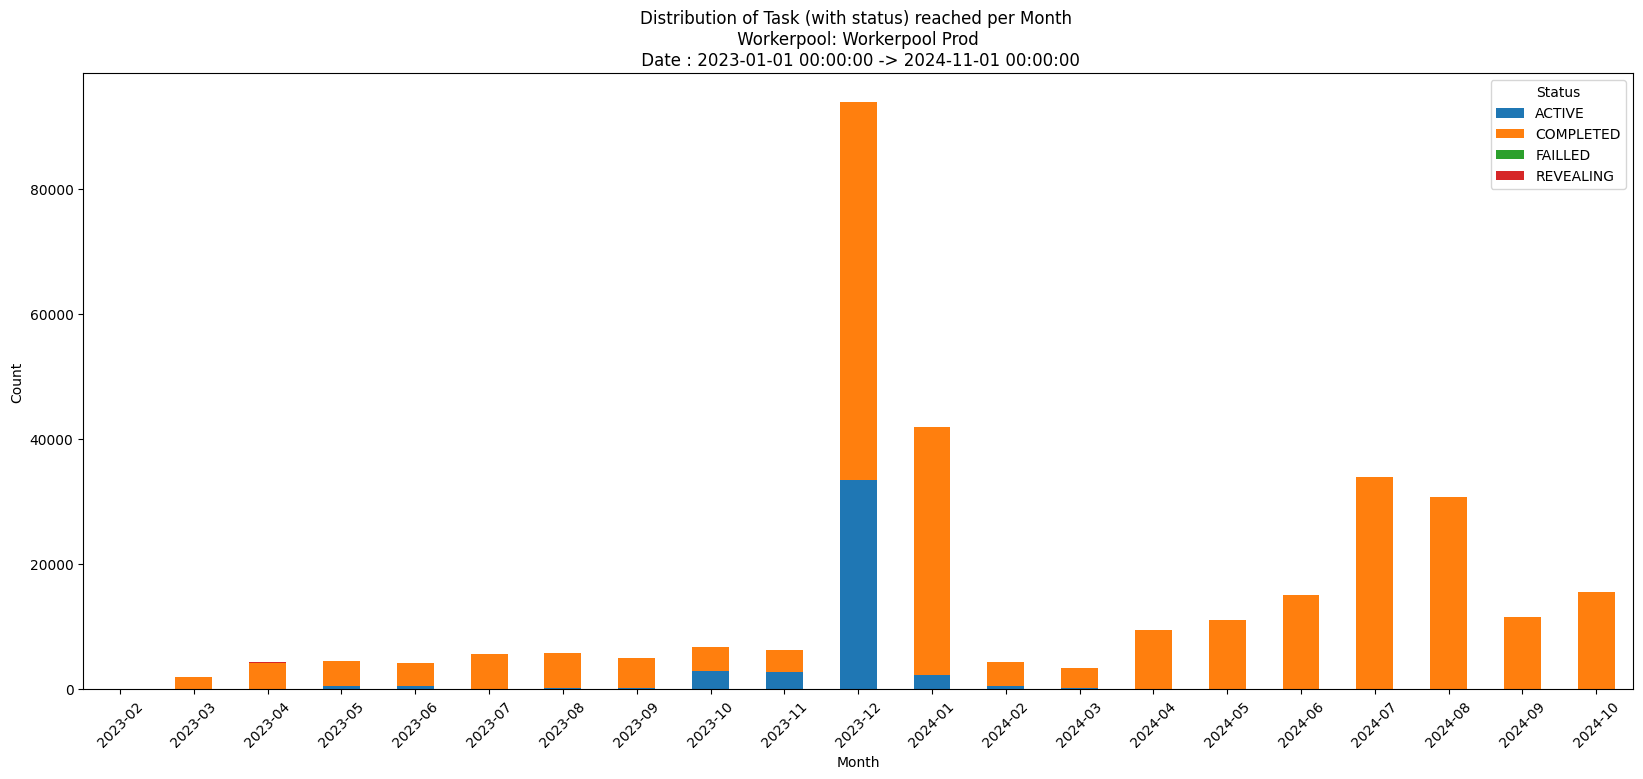

<ipython-input-13-cd23dae5b53f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


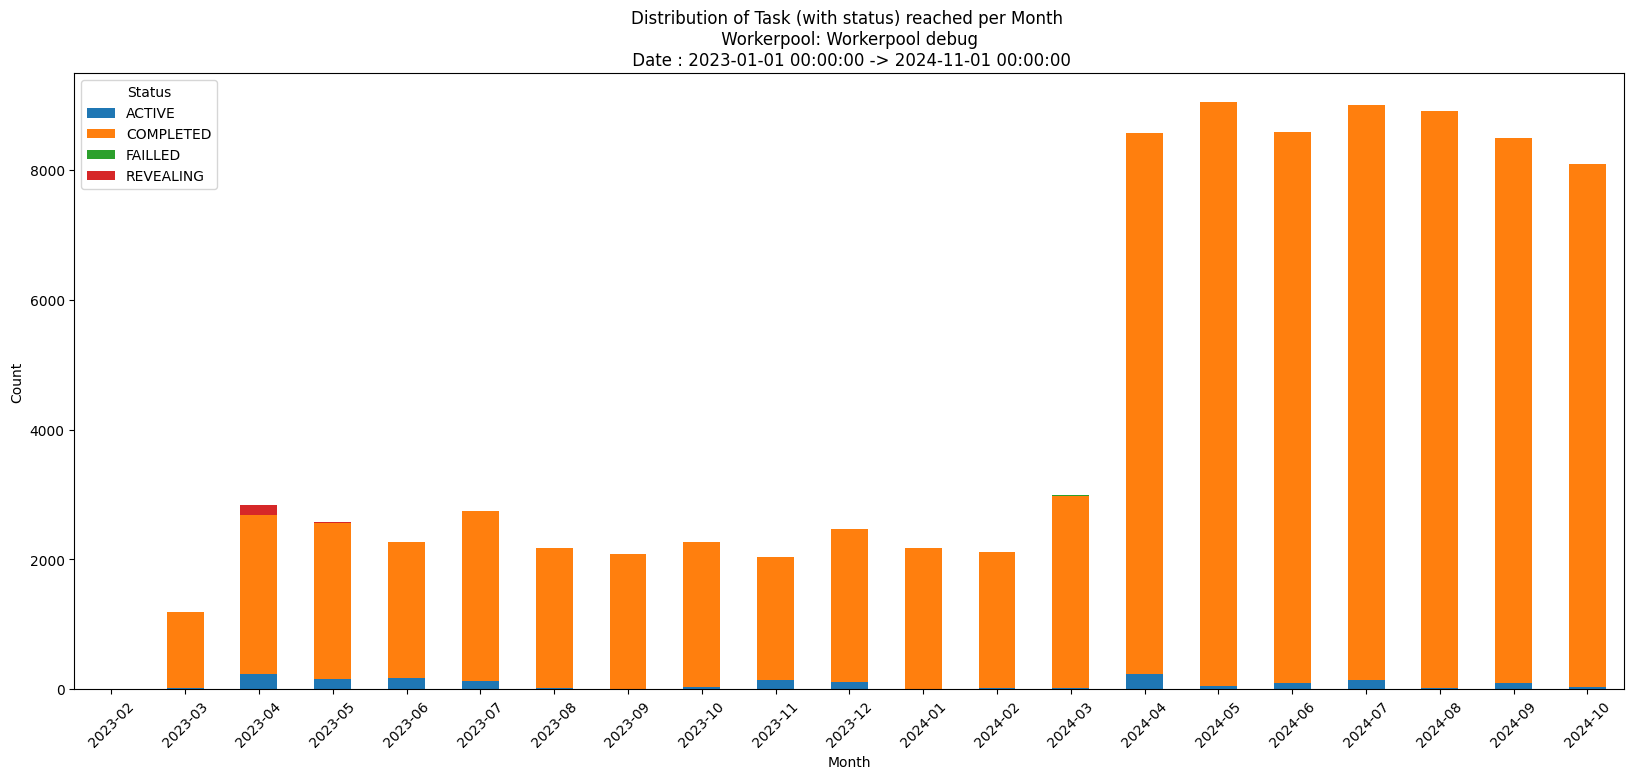

<ipython-input-13-cd23dae5b53f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


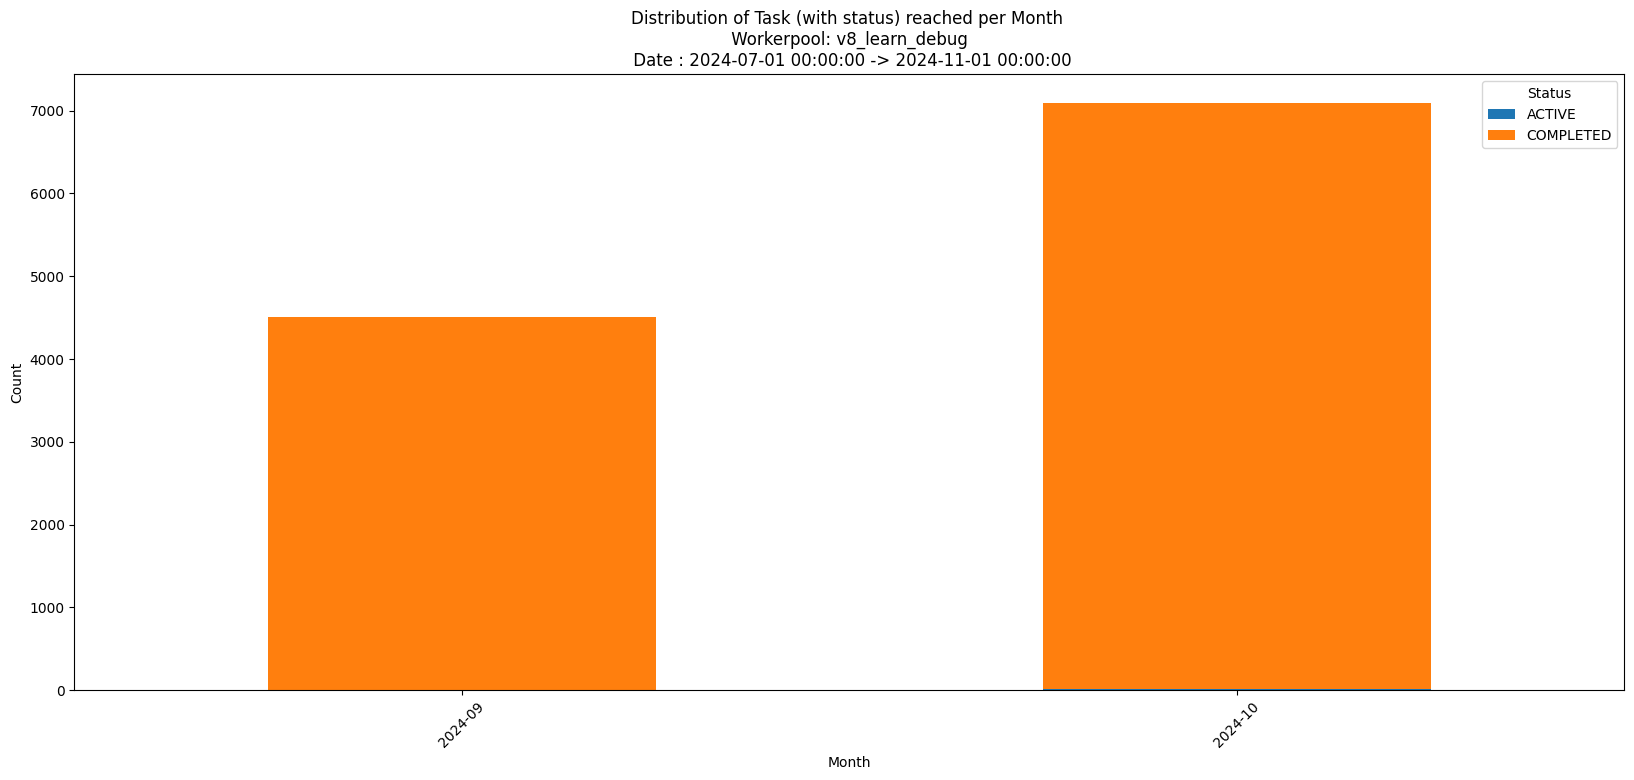

<ipython-input-13-cd23dae5b53f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


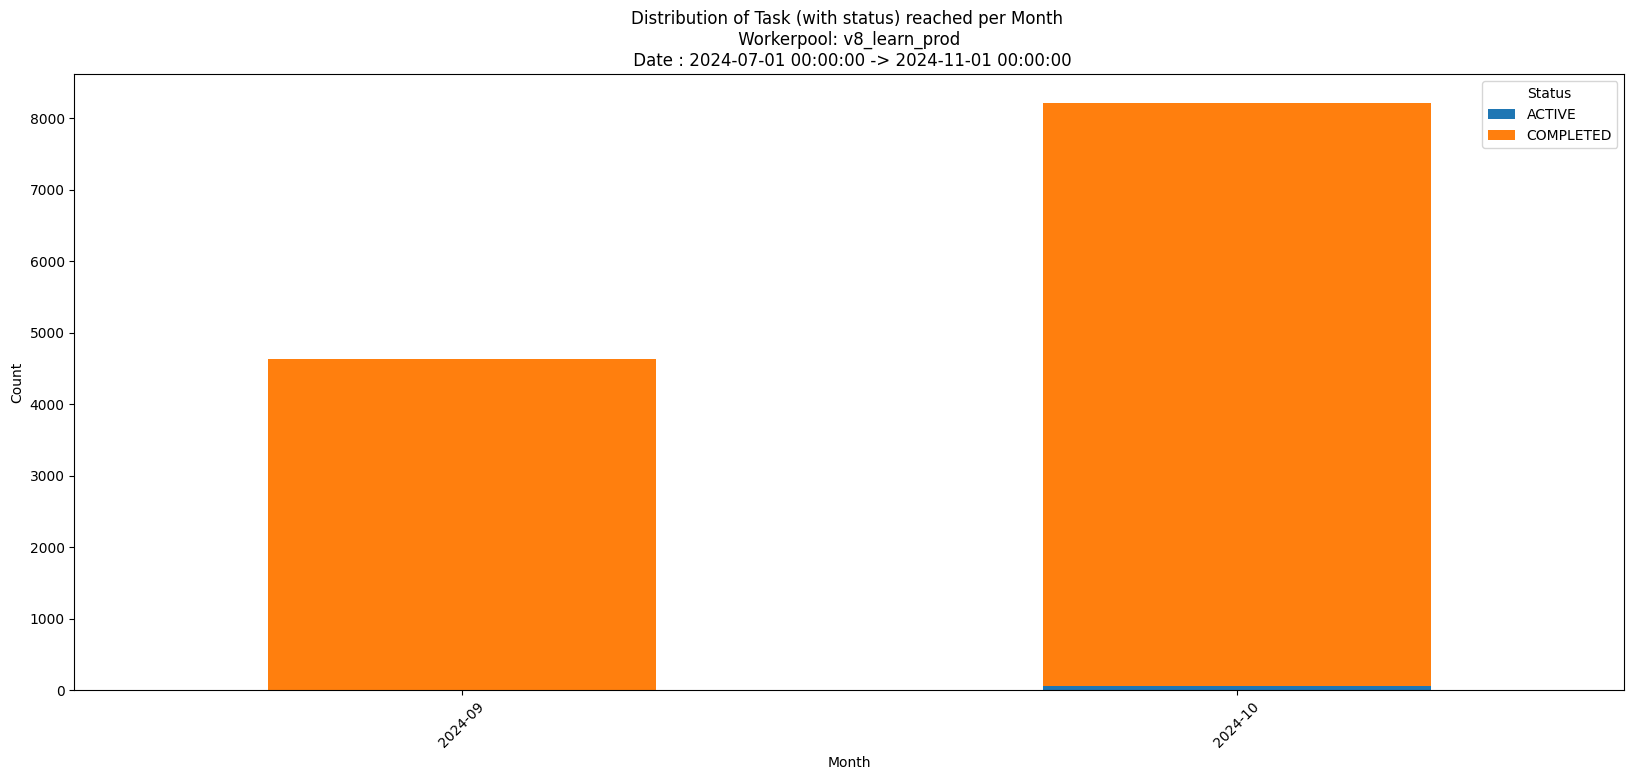

<ipython-input-13-cd23dae5b53f>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')
<ipython-input-13-cd23dae5b53f>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')
<ipython-input-13-cd23dae5b53f>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

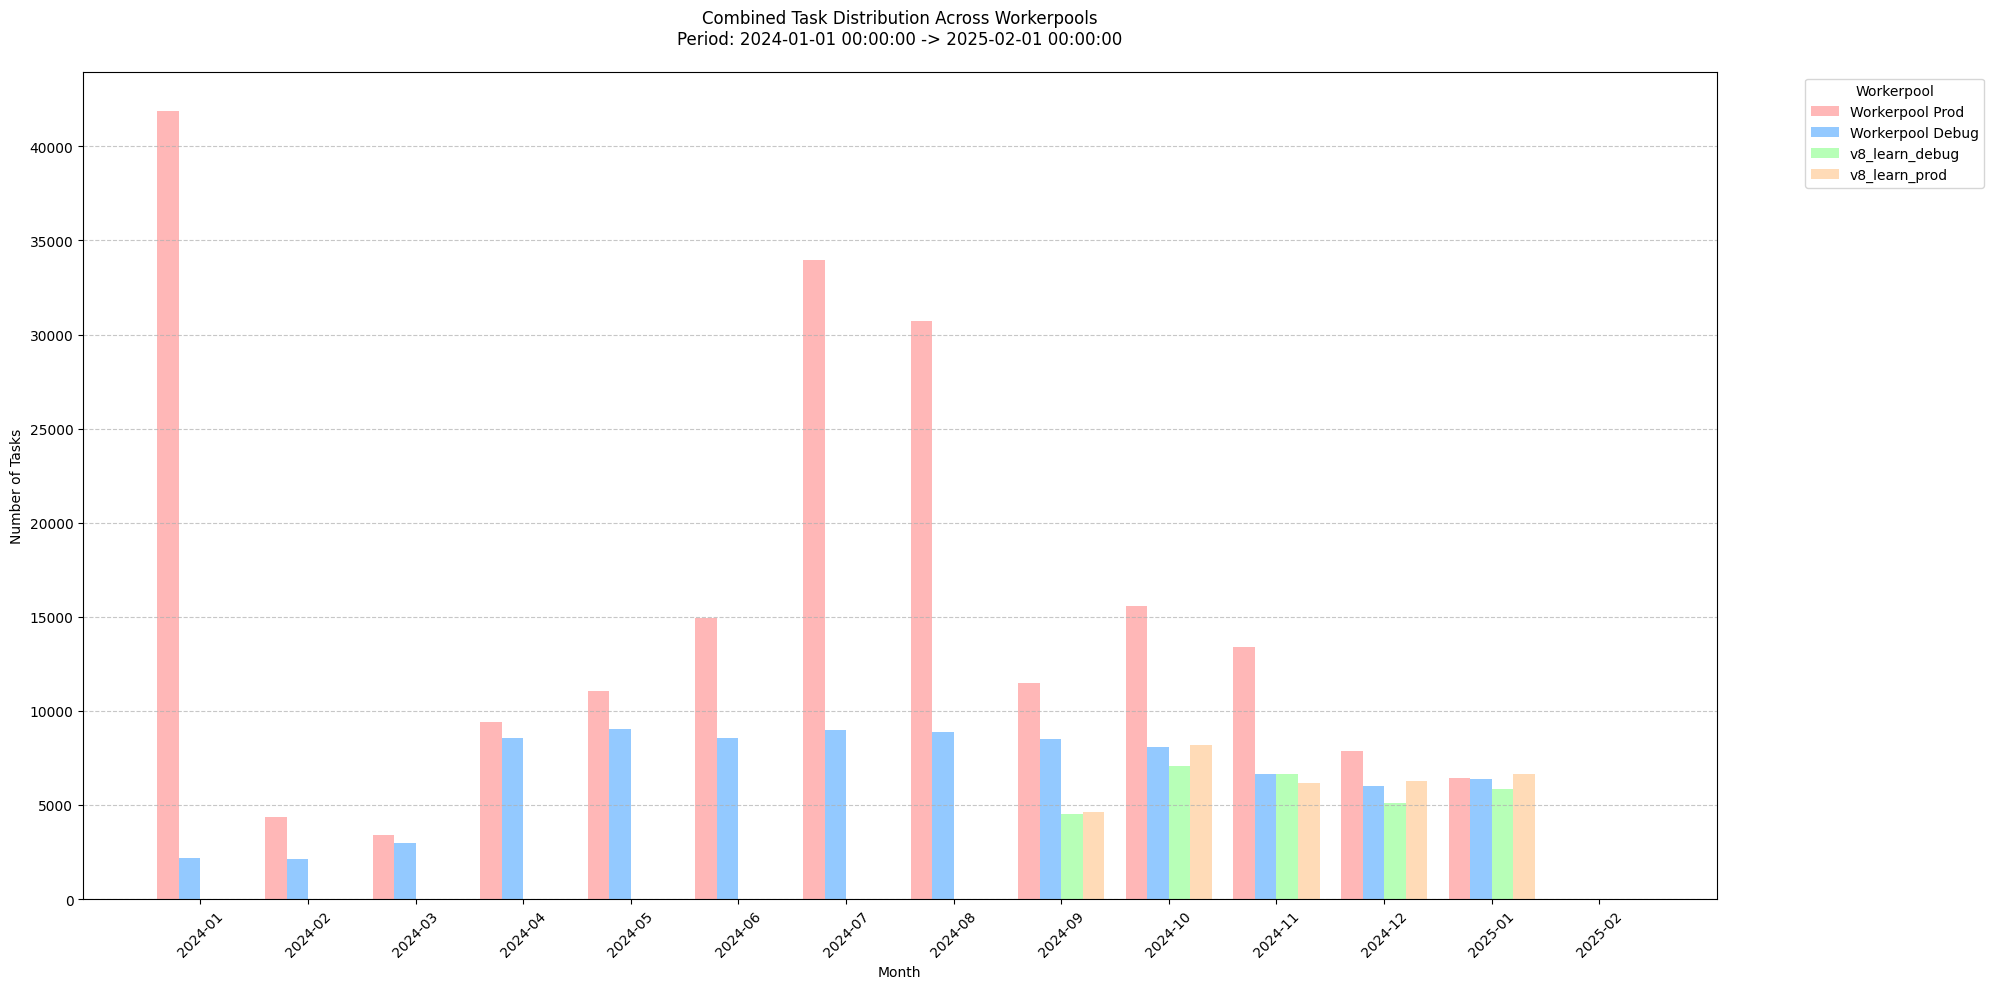

In [13]:
# @title Month activity on 4 main workerpools

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
v8_learn_prod = '0x0975bfce90f4748dab6d6729c96b33a2cd5491f5'
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'

def month_plot(df, workerpool_filter, start, end, wp_name):
    date_begin = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    # Convert start and end dates to datetime if they are not already
    if isinstance(start, str):
        start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    if isinstance(end, str):
        end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Filter the DataFrame with date start, end
    df['DATE'] = pd.to_datetime(df['DATE'])
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]

    # Filter the DataFrame further for the specific worker pool
    df_prodhist = df_filtered[df_filtered['WORKERPOOL ID'] == workerpool_filter]

    # Debug: Check workerpool filtered DataFrame
    # Extract month from the DATE column
    df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')

    # Group by Month and STATUS, count occurrences
    status_counts = df_prodhist.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    if not status_counts.empty:
        status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
#      plt.title(f'Distribution of Task (with status) reached per Month - {wp_name}')
        plt.title('Distribution of Task (with status) reached per Month \n Workerpool: {} \n Date : {} -> {}'.format(wp_name, start, end))
        plt.xlabel('Month')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Status')
        plt.show()
    else:
        print("[DEBUG] No numeric data to plot.")

# Example usage

month_plot(concatenated_df, workerpool_prod,'2023-01-01 00:00:00','2024-11-01 00:00:00', "Workerpool Prod")
month_plot(concatenated_df, workerpool_debug,'2023-01-01 00:00:00','2024-11-01 00:00:00', "Workerpool debug")
month_plot(concatenated_df, v8_learn_debug,'2024-07-01 00:00:00','2024-11-01 00:00:00', "v8_learn_debug")
month_plot(concatenated_df, v8_learn_prod,'2024-07-01 00:00:00','2024-11-01 00:00:00', "v8_learn_prod")

import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def combined_workerpool_plot(df, workerpool_configs, start, end):
    """
    Create a combined plot for multiple workerpools showing task distribution over time.
    All workerpools will use the same date range for comparison.

    Args:
        df: DataFrame with the data
        workerpool_configs: List of tuples containing (workerpool_id, name)
        start: Global start date for all workerpools
        end: Global end date for all workerpools
    """
    # Convert dates to datetime
    date_start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Convert DataFrame dates
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Create figure with subplots
    fig, ax = plt.subplots(figsize=(20, 10))

    # Color palette for different workerpools
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    # Filter the main DataFrame for the date range
    df_date_filtered = df[(df['DATE'] >= date_start) & (df['DATE'] <= date_end)]

    # Store data for plotting
    all_monthly_counts = []

    for idx, (workerpool_id, name) in enumerate(workerpool_configs):
        # Filter for this workerpool
        df_filtered = df_date_filtered[df_date_filtered['WORKERPOOL ID'] == workerpool_id]

        # Get monthly counts
        df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')
        monthly_counts = df_filtered.groupby('Month').size()

        # Ensure all months are present (fill missing months with 0)
        date_range = pd.period_range(start=date_start, end=date_end, freq='M')
        monthly_counts = monthly_counts.reindex(date_range, fill_value=0)

        # Store data for plotting
        all_monthly_counts.append((monthly_counts, name, colors[idx]))

    # Plot all workerpools
    bar_width = 0.2
    for idx, (counts, name, color) in enumerate(all_monthly_counts):
        positions = [i + (idx * bar_width) for i in range(len(counts))]
        plt.bar(positions, counts.values, bar_width,
                label=name, color=color, alpha=0.7)

    # Customize plot
    plt.title('Combined Task Distribution Across Workerpools\n'
              f'Period: {start} -> {end}', pad=20)
    plt.xlabel('Month')
    plt.ylabel('Number of Tasks')

    # Set x-axis labels
    if all_monthly_counts:
        months = all_monthly_counts[0][0].index
        plt.xticks([i + (bar_width * (len(workerpool_configs)-1)/2) for i in range(len(months))],
                  months.astype(str),
                  rotation=45)

    plt.legend(title='Workerpool', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

# Example usage
workerpool_configs = [
    (workerpool_prod, "Workerpool Prod"),
    (workerpool_debug, "Workerpool Debug"),
    (v8_learn_debug, "v8_learn_debug"),
    (v8_learn_prod, "v8_learn_prod")
]

fig = combined_workerpool_plot(concatenated_df, workerpool_configs,
                             '2024-01-01 00:00:00', '2025-02-01 00:00:00')
plt.show()

In [24]:
# @title App table on 4 main workerpool

import pandas as pd

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
v8_learn_prod = '0x0975bfce90f4748dab6d6729c96b33a2cd5491f5'
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'

def month_table(df, workerpool_filter, start, end, wp_name, filename=None):
    # Filter the DataFrame with date start, end
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]

    # Filter the DataFrame further for the specific worker pool
    df_filtered = df_filtered[df_filtered['WORKERPOOL ID'] == workerpool_filter]

    # Extract month from the DATE column
    df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')

    # Group by Month and APP NAME, count occurrences
    app_counts = df_filtered.groupby(['Month', 'APP NAME']).size().unstack(fill_value=0)

    # Add a "Total" column to calculate the sum of each row
    app_counts['Total'] = app_counts.sum(axis=1)

    # Transpose the DataFrame to reverse lines and columns
    app_counts_sorted_transposed = app_counts.T

    # Add a column for the total for each line
    app_counts_sorted_transposed['Total'] = app_counts_sorted_transposed.sum(axis=1)

    # Sort the DataFrame by the "Total" column
    app_counts_sorted_transposed = app_counts_sorted_transposed.sort_values(by='Total', ascending=False)

    # Format the transposed DataFrame as a table
    csvtable = app_counts_sorted_transposed
    table = app_counts_sorted_transposed.to_string()

    # Display the table
    print('App usage per month on Workerpool: {} {} \nPeriod: [{} -> {}]\n'.format(wp_name, workerpool_filter, start, end))
    print(table)

    # Save the table to a CSV file if filename is provided
    if filename:
        app_counts_sorted_transposed.to_csv(filename)
        print(f'Table saved to {filename}')

    return csvtable


# Example usage
summary_prod=month_table(concatenated_df, workerpool_prod, '2024-09-01 00:00:00', '2025-05-01 00:00:00', "Workerpool Prod")
summary_debug=month_table(concatenated_df, workerpool_debug, '2024-09-01 00:00:00', '2025-05-01 00:00:00', "Workerpool Debug")
summary_learn_prod=month_table(concatenated_df, v8_learn_prod, '2024-09-01 00:00:00', '2025-05-01 00:00:00', "v8_learn_prod")
summary_learn_debug=month_table(concatenated_df, v8_learn_debug, '2024-09-01 00:00:00', '2025-05-01 00:00:00', "v8_learn_debug")

#month_table(concatenated_df, workerpool_prod, '2023-01-01 00:00:00', '2024-11-01 00:00:00', "V8 prod", filename="/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/V8-prod_Jan23-may24.csv")
#month_table(concatenated_df, workerpool_debug, '2023-01-01 00:00:00', '2024-11-01 00:00:00', "V8 debug",filename="/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/V8-debug_Jan23-may24.csv")

#summary_prod.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-prod.csv")
#summary_debug.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-debug.csv")
#summary_learn_prod.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-learn-prod.csv")
#summary_learn_debug.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-learn-debug.csv")

App usage per month on Workerpool: Workerpool Prod 0x0e7bc972c99187c191a17f3cae4a2711a4188c3f 
Period: [2024-09-01 00:00:00 -> 2025-05-01 00:00:00]

Month                                                  2024-09  2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  2025-05  Total
APP NAME                                                                                                                                     
Total                                                    11480    15566    13390     7892     6431    20759     9165     8707        1  93391
python-hello-world:8.0.0-sconify-5.7.6-v15-production     8524     8003     6706     6076     6380     5618     7823     8198        1  57329
web3mail                                                    39     4455     6684     1816       50    15133     1325      458        0  29960
generic-oracle-dapp                                       2872     2925        0        0        0        0        0        0        0   5797

In [15]:
# @title table saving

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def save_period(df, start, end, filename):
    date_begin = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    # Convert start and end dates to datetime if they are not already
    if isinstance(start, str):
        start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    if isinstance(end, str):
        end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Filter the DataFrame with date start, end
    df['DATE'] = pd.to_datetime(df['DATE'])
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]


    print("Period observed", df_filtered["DATE"].min(), df_filtered["DATE"].max())
    print("dataset length: " + str(df_filtered.shape[0]))


    # Save the DataFrame to CSV with the new filename !!! uncomment
    #df_filtered.to_csv(filename, index=False)


#filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/tasks_2023.csv'
#save_period(concatenated_df,'2023-01-01 00:00:00','2024-01-01 00:00:00',filename)

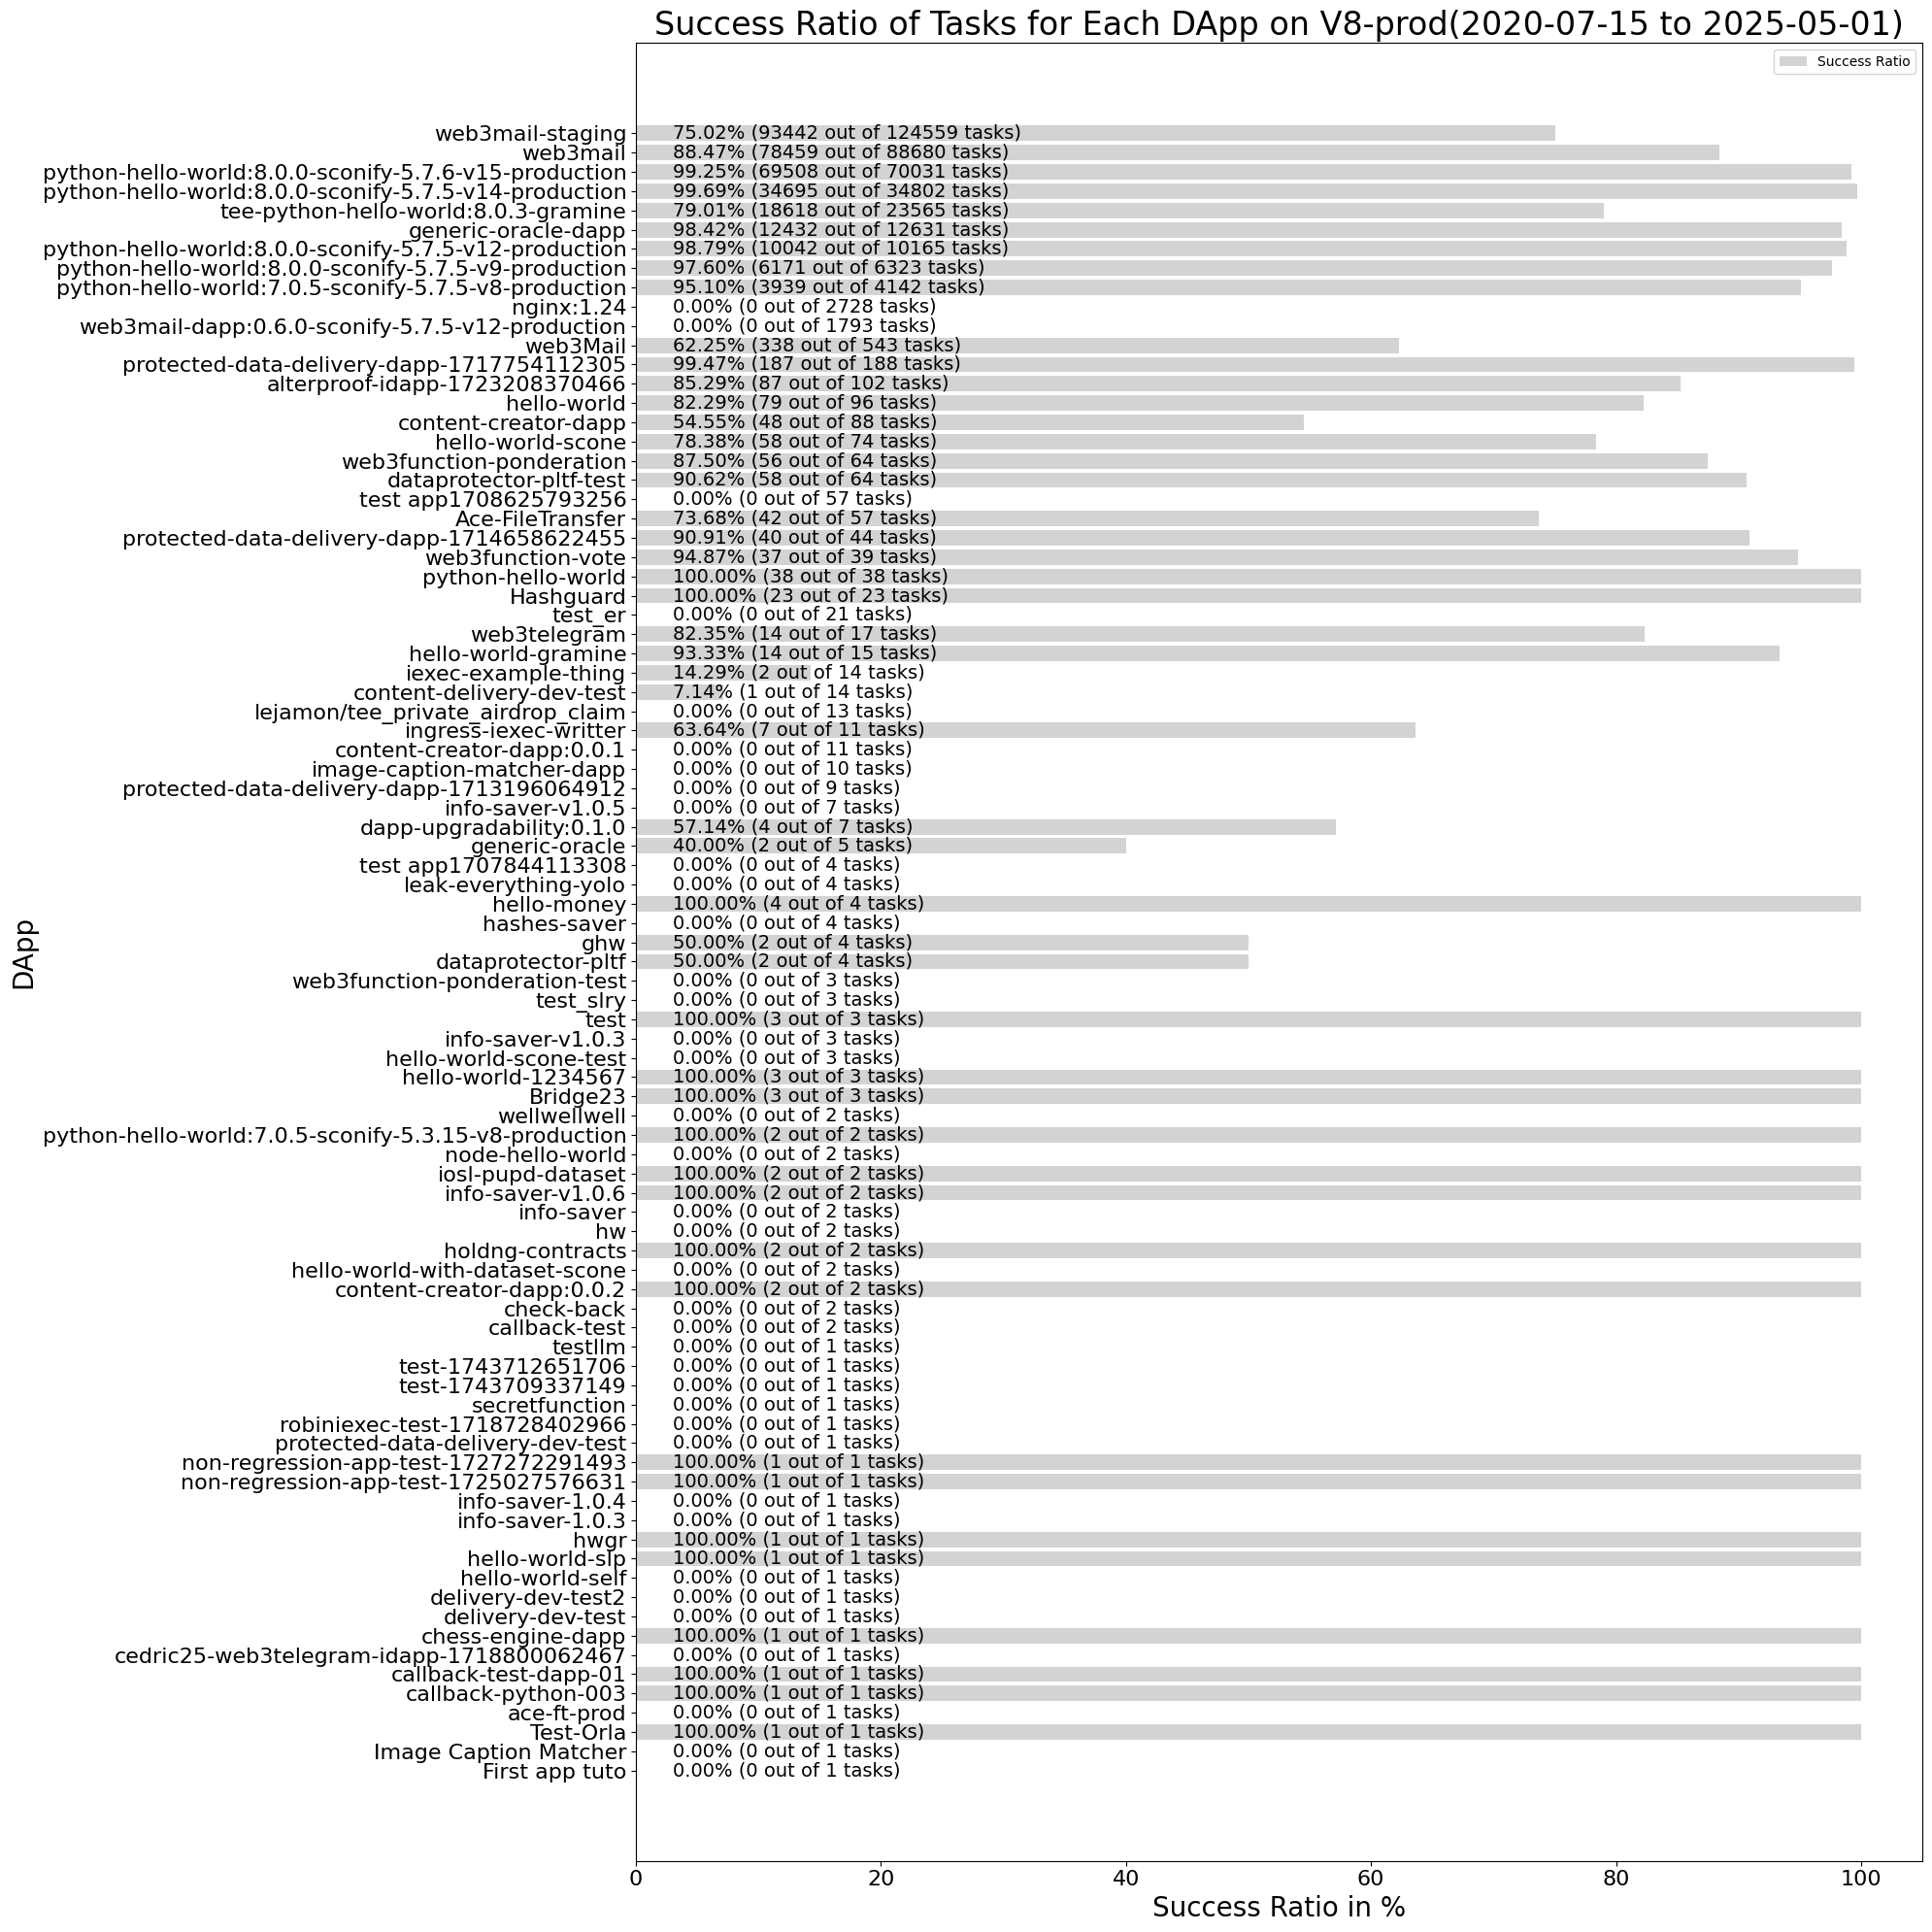

In [16]:
# @title Apps success ratio [only v8-prod]

import matplotlib.pyplot as plt

# Filter the DataFrame further for the specific worker pool
workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
df_prodhist = concatenated_df[concatenated_df['WORKERPOOL ID'] == workerpool_prod]
# Calculate the success ratio for each DApp
dapp_data = {}
for dapp, group in df_prodhist.groupby('APP NAME'):
    total_count = group.shape[0]
    success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
    ratio = success_count / total_count * 100 if total_count != 0 else 0
    dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

# Sort dapp_data by total_count
sorted_dapp_data = sorted(dapp_data.items(), key=lambda x: x[1]['total_count'], reverse=False)

# Create a bar plot
plt.figure(figsize=(20, 20))
plt.barh([dapp[0] for dapp in sorted_dapp_data], [d[1]['ratio'] for d in sorted_dapp_data], color='lightgrey', label='Success Ratio')
plt.xlabel('Success Ratio in %', fontsize=20)  # Set larger fontsize for xlabel
plt.ylabel('DApp', fontsize=20)  # Set larger fontsize for ylabel
plt.title(f'Success Ratio of Tasks for Each DApp on V8-prod({date_begin} to {date_end})', fontsize=24)  # Set larger fontsize for title
plt.legend()

# Set larger fontsize for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add annotations for success ratio and total task count
for i, (dapp, data) in enumerate(sorted_dapp_data):
    plt.text(3 , i, f'{data["ratio"]:.2f}% ({data["success_count"]} out of {data["total_count"]} tasks)', verticalalignment='center', fontsize=14)  # Set larger fontsize for annotations

plt.tight_layout()

# Save the plot before displaying it
output_path = "/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/Dashboard_from_collab"
#filename = output_path + "/Dapp_Success_rate_on_V8-prod-alltime.jpg"
#plt.savefig(filename)

# Display the plot
plt.show()


Down Intervals:
 [ 2024-01-19 12:37:55  -> 2024-01-19 13:37:15 ] Duration: 0 days 00:59:20 
 [ 2024-01-19 13:57:35  -> 2024-01-19 14:22:25 ] Duration: 0 days 00:24:50 
 [ 2024-01-19 15:37:55  -> 2024-01-19 16:17:50 ] Duration: 0 days 00:39:55 
 [ 2024-01-19 16:17:50  -> 2024-01-19 16:43:05 ] Duration: 0 days 00:25:15 
 [ 2024-01-19 16:43:05  -> 2024-01-19 16:56:40 ] Duration: 0 days 00:13:35 
 [ 2024-01-19 16:56:40  -> 2024-01-19 17:22:45 ] Duration: 0 days 00:26:05 
 [ 2024-01-19 17:37:30  -> 2024-01-19 18:17:50 ] Duration: 0 days 00:40:20 
 [ 2024-01-19 19:37:50  -> 2024-01-19 20:17:45 ] Duration: 0 days 00:39:55 
 [ 2024-01-19 20:17:45  -> 2024-01-19 20:57:15 ] Duration: 0 days 00:39:30 
 [ 2024-01-19 20:57:15  -> 2024-01-19 21:17:00 ] Duration: 0 days 00:19:45 
 [ 2024-01-19 21:17:00  -> 2024-01-19 21:38:00 ] Duration: 0 days 00:21:00 
 [ 2024-01-19 23:39:00  -> 2024-01-20 00:17:40 ] Duration: 0 days 00:38:40 
 [ 2024-01-20 00:17:40  -> 2024-01-20 00:37:45 ] Duration: 0 days 00:20:

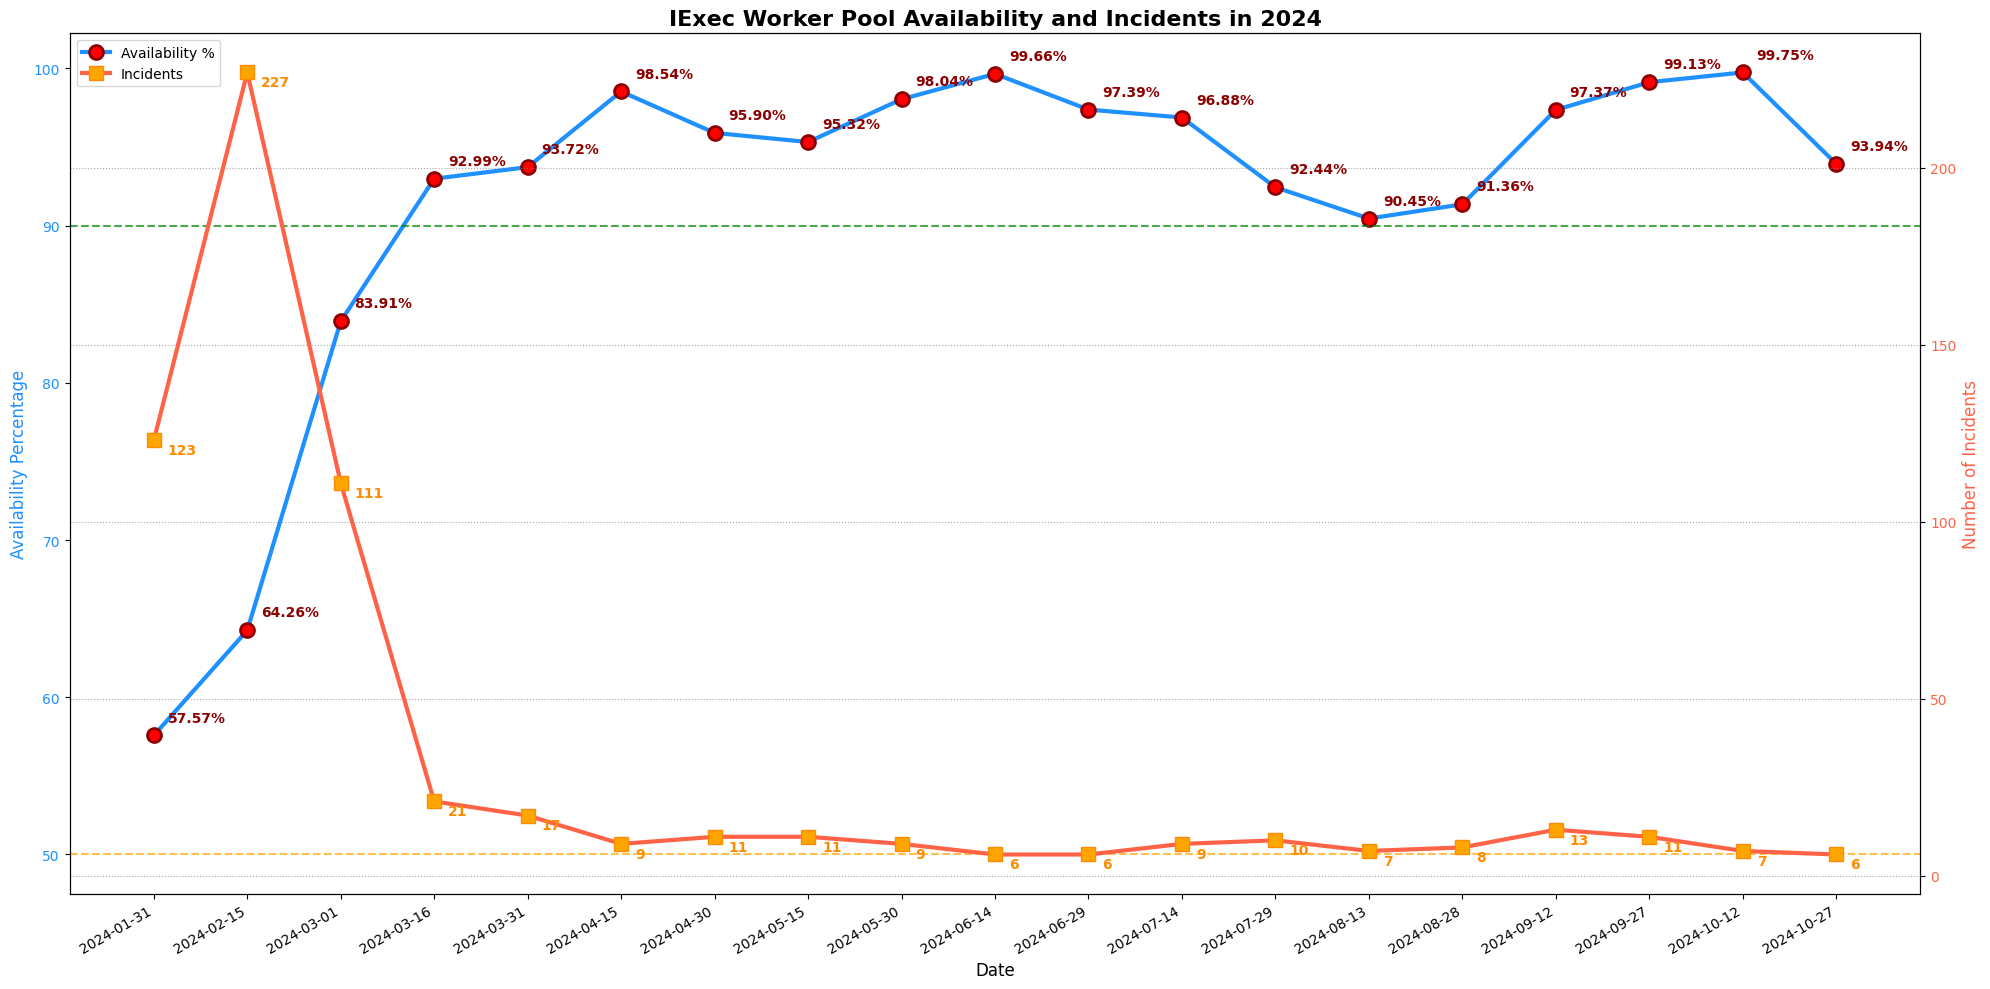

In [17]:
# @title Availibility history

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Assuming df_alltime_specific contains your DataFrame with the provided structure

def availability(df, workerpool_filter, start, end):
    # Filter the DataFrame further for the specific worker pool
    df_filtered = df[df['WORKERPOOL ID'] == workerpool_filter]
    df_filtered = df_filtered.sort_values(by='DATE')
    specific_app1 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.5-v14-production'
    specific_app2 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.6-v15-production'

    # Filter for specific applications
    df_filtered = df_filtered[(df_filtered['APP MULTIADDR'] == specific_app1) | (df_filtered['APP MULTIADDR'] == specific_app2)].copy()

    # Filter the DataFrame with date start, end
    df_filtered = df_filtered[(df_filtered['DATE'] >= start) & (df_filtered['DATE'] <= end)]

    test = df_filtered
    # Initialize variables to track "up" time intervals and downtime intervals
    up_intervals = []
    down_intervals = []

    # Initialize variables to track the start time and count of successful tasks within the interval
    start_time = None
    success_count = 0
    test.index = pd.RangeIndex(1, len(test.index) + 1)
    up = pd.Timedelta(0)
    down = pd.Timedelta(0)
    down_intervals = []

    # Iterate over the sorted DataFrame
    for index, row in test.iterrows():
        if index < len(test) - 1:
            next_row = test.loc[index + 1]

            # Check if both the current and next observations are COMPLETED
            if (row["STATUS"] == "COMPLETED") and (next_row["STATUS"] == "COMPLETED"):
                # Check if the time between the current and next observations is less than or equal to 22 minutes
                if (next_row['DATE'] - row["DATE"]) <= pd.Timedelta(minutes=22):
                    up += next_row['DATE'] - row["DATE"]
                else:
                    # If the time between observations is more than 22 minutes, it's considered as down
                    down += next_row['DATE'] - row["DATE"]
                    down_intervals.append((row['DATE'], next_row["DATE"]))
            else:
                # If either the current or next observation is not COMPLETED, it's considered as down
                down += next_row['DATE'] - row["DATE"]
                down_intervals.append((row['DATE'], next_row["DATE"]))

    # Print down intervals
    print("Down Intervals:")
    for start, end in down_intervals:
        start_time = start.strftime('%Y-%m-%d %H:%M:%S')
        end_time = end.strftime('%Y-%m-%d %H:%M:%S')
        print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

    # Merge consecutive intervals
    compressed_intervals = []

    # Check if down_intervals is not empty before processing
    if down_intervals:
        start, end = down_intervals[0]
        for interval in down_intervals[1:]:
            if interval[0] - end <= pd.Timedelta(minutes=1):
                end = interval[1]
            else:
                compressed_intervals.append((start, end))
                start, end = interval
        compressed_intervals.append((start, end))

        print("Down compressed:")

        # Print compressed intervals
        print("\nDown compressed Intervals:")
        for start, end in compressed_intervals:
            start_time = start.strftime('%Y-%m-%d %H:%M:%S')
            end_time = end.strftime('%Y-%m-%d %H:%M:%S')
            print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")
    else:
        print("No down intervals to compress")

    # Calculate total time, availability percentage
    total_time = df_filtered["DATE"].max() - df_filtered["DATE"].min()

    # Add a check to prevent division by zero
    if up + down > pd.Timedelta(0):
        up_percentage = (up / (up + down)) * 100
    else:
        up_percentage = 0

    # Print summary
    print("\nSummary:")
    print(f"Total Time: {total_time}")
    print(f"Up period: {up}")
    print(f"Down period: {down}")
    print(f"Availability Percentage: {up_percentage}%")
    return up_percentage, len(compressed_intervals)

# Define the worker pool
workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'

# Define the date range
start_date = datetime.strptime('2024-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2024-11-01 00:00:00', '%Y-%m-%d %H:%M:%S')

# Calculate availability every 15 days
current_date = start_date
result = []
while current_date < end_date - timedelta(days=30):
    next_date = current_date + timedelta(days=30)
    avail,down_intervals_nb = availability(concatenated_df, workerpool_prod, current_date, next_date)
    current_date = current_date + timedelta(days=15)
    result.append((next_date.strftime('%Y-%m-%d'), avail,down_intervals_nb))

print(result)

# Plotting
x_val = [res[0] for res in result]   # date
y_val = [res[1] for res in result]   # availibiity ratio
y2_val = [res[2] for res in result]  # Number of incidents

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot availability percentage on primary y-axis
color1 = '#1E90FF'  # Dodger blue for availability
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Availability Percentage', color=color1, fontsize=12)
line1 = ax1.plot(x_val, y_val,
                 color=color1,
                 linewidth=3,
                 linestyle='-',
                 marker='o',
                 markersize=10,
                 markerfacecolor='red',
                 markeredgecolor='darkred',
                 markeredgewidth=2,
                 label='Availability %')

# Add value labels for availability
for i, txt in enumerate(y_val):
    ax1.annotate(f'{txt:.2f}%',
                 (x_val[i], y_val[i]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontweight='bold',
                 color='darkred')

# Customize primary axis
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=90, color='green', linestyle='--', alpha=0.7)
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7)

# Create secondary y-axis for incidents
ax2 = ax1.twinx()
color2 = '#FF6347'  # Tomato red for incidents
ax2.set_ylabel('Number of Incidents', color=color2, fontsize=12)
line2 = ax2.plot(x_val, y2_val,
                 color=color2,
                 linewidth=3,
                 linestyle='-',
                 marker='s',
                 markersize=10,
                 markerfacecolor='orange',
                 markeredgecolor='darkorange',
                 label='Incidents')

# Add value labels for incidents
for i, txt in enumerate(y2_val):
    ax2.annotate(str(txt),
                 (x_val[i], y2_val[i]),
                 xytext=(10, -10),
                 textcoords='offset points',
                 fontweight='bold',
                 color='darkorange')

# Customize secondary axis
ax2.tick_params(axis='y', labelcolor=color2)

# Title and overall formatting
plt.title('IExec Worker Pool Availability and Incidents in 2024', fontsize=16, fontweight='bold')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Improve layout
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle=':', color='gray', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()